# CE PTP Analysis Notebook

In [1]:
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))

## Importing Python Libraries & Starting Spark Session

In [2]:
#Import useful libraries
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
from pyspark.sql.functions import col, max as max_
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, BooleanType, StringType, IntegerType, ArrayType, DateType
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.labelsize']= 15
plt.rcParams['ytick.labelsize']= 15
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
#Start spark session
if "spark" in globals():
    spark.stop()
        
spark = SparkSession.builder \
                    .master("yarn") \
                    .appName("CE_PTP_Analysis2") \
                    .config("spark.yarn.queue", "apps") \
                    .config('spark.executor.instances', '10') \
                    .config('spark.executor.memory', '10g') \
                    .config('spark.executor.cores', '8') \
                    .config('spark.sql.shuffle.partitions', '2000') \
                    .config('spark.sql.orc.mergeSchema', 'true') \
                    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
                    .config('spark.default.parallelism', '2000') \
                    .config('spark.driver.maxResultSize', '20g') \
                    .config('spark.kryoserializer.buffer.max.mb', '512')\
                    .enableHiveSupport() \
                    .getOrCreate()

In [4]:
spark

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Intro - directories overview, last reactive PTP runs, setting variables

###  Hadoop directory overview LS command

In [20]:
!hdfs dfs -ls /insight_uat/rdf/output/ptp/ensemble_ptp/cz/ensemble_ptp/

Found 4 items
-rw-------   3 svc-rdf-uat hdfs          0 2024-04-17 09:04 /insight_uat/rdf/output/ptp/ensemble_ptp/cz/ensemble_ptp/_SUCCESS
drwx------   - svc-rdf-uat hdfs          0 2024-04-17 09:07 /insight_uat/rdf/output/ptp/ensemble_ptp/cz/ensemble_ptp/execution_date=2024-03-18 00%3A00%3A00
drwx------   - svc-rdf-uat hdfs          0 2024-04-17 09:07 /insight_uat/rdf/output/ptp/ensemble_ptp/cz/ensemble_ptp/execution_date=2024-03-25 00%3A00%3A00
drwx------   - svc-rdf-uat hdfs          0 2024-04-17 09:06 /insight_uat/rdf/output/ptp/ensemble_ptp/cz/ensemble_ptp/execution_date=2024-04-15 00%3A00%3A00


###  Setting country 

In [24]:
#Select a country to analyse. The country codes are as follows: Hungary = hu, Czech = cz, and Slovakia = sk
country = 'sk'

###  Last reactive PTP runs

In [25]:
schema = StructType([StructField("execution_date", DateType(), True)])
# Read ORC file with specified schema and select required columns
dfruns = spark.read.schema(schema).orc('/insight_prod/rdf_archive/output/ptp/reactive_ptp/'+country+'/reactive_ptp_P_U_Table')\
            .select('execution_date').distinct()
dfruns = dfruns.withColumn('execution_date_lw',date_sub(dfruns['execution_date'],7))

querycal = "SELECT calendar_date,year_week_number FROM lookup.calendar"
cal = spark.sql(querycal)       
df_info = dfruns.join(cal,dfruns['execution_date_lw']==cal['calendar_date'],how='left').select(dfruns['*'],cal['year_week_number'])
df_info = df_info.withColumnRenamed('year_week_number','last_used_year_week')
df_info = df_info.withColumn('country',lit(country))
df_info = df_info.join(cal,df_info['execution_date']==cal['calendar_date'],how='left').select(df_info['*'],cal['year_week_number'])
df_info = df_info.orderBy(col('execution_date').desc())
df_info = df_info.select('country', col('execution_date').cast(DateType()), 'year_week_number', 'last_used_year_week')
df_info.cache()
                                                                                                                     
curr_date = spark.sql('SELECT calendar_date,year_week_number FROM lookup.calendar WHERE calendar_date = CURRENT_DATE')
curr_date_p = curr_date.toPandas()
lw = curr_date_p.iloc[0,1]
df_info = df_info.withColumn('ID',lit(1))
cal2 = spark.sql("SELECT calendar_date,year_week_number FROM lookup.calendar WHERE day_number = 1 AND calendar_date > '2022-01-01'")

df_info_graph = cal2.join(df_info,cal2['calendar_date']==df_info['execution_date'],how='left').select(cal2['*'],df_info['country'], df_info['last_used_year_week'], df_info['ID'],df_info['execution_date'])
df_info_graph = df_info_graph.filter(col('year_week_number')<= int(lw))
df_info = df_info.withColumn('good_bad_week',lit('good'))
df_info_p = df_info.toPandas()
df_info_p2 = df_info_p[['country','execution_date','year_week_number','last_used_year_week']].copy()
df_info_graph_p = df_info_graph.toPandas()

df_info_graph_p = df_info_graph_p.merge(df_info_p[['last_used_year_week','good_bad_week']],how='left',left_on='year_week_number',right_on='last_used_year_week')
df_info_graph_p['good_bad_week'].fillna('bad',inplace=True)
df_info_graph_p['execution_date'].fillna(pd.to_datetime('1900-01-01'), inplace=True)
df_info_graph_p['PTP_run'] =  df_info_graph_p['execution_date'].apply(lambda x: 'Yes' if x>pd.to_datetime('2000-01-01') else 'No')
df_info_graph_p.rename(columns={'calendar_date':'Monday_calendar_date','good_bad_week_y':'good_bad_week'},inplace=True)
df_info_graph_p.sort_values(by='Monday_calendar_date',ascending=True,inplace=True)
csvname = 'bad_week_ptp_run_'+country+".csv"
df_info_graph_p.to_csv(csvname,index=False)

print("Last 5 PTP runs: \n")
print(df_info_p2.head(5))

Last 5 PTP runs: 

  country execution_date  year_week_number  last_used_year_week
0      sk     2024-04-15            202408               202407
1      sk     2024-03-25            202405               202404
2      sk     2024-03-18            202404               202403
3      sk     2024-03-11            202403               202402
4      sk     2024-03-04            202402               202401


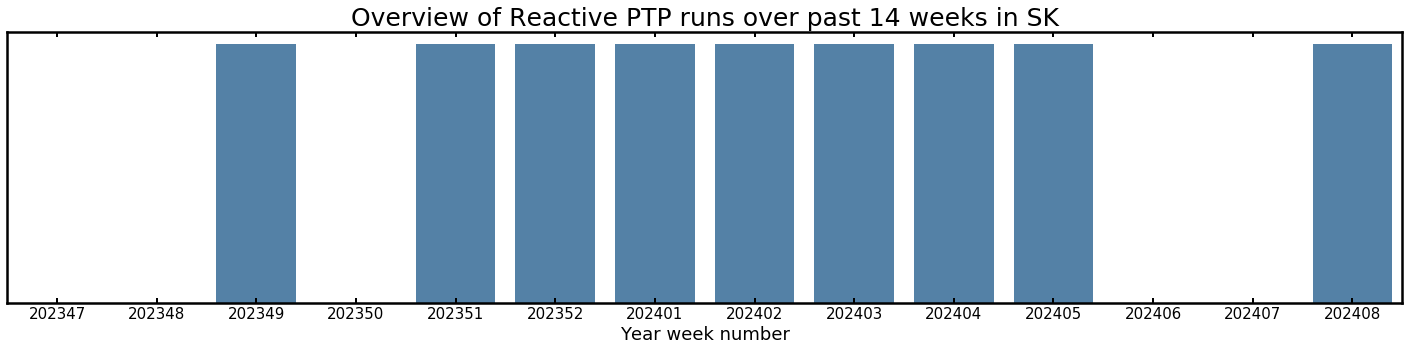

In [26]:
df_info.unpersist()
df_info_graph_p = df_info_graph_p[['year_week_number','ID']].sort_values(by='year_week_number',ascending=False).iloc[:14,:].reset_index(drop=True)
df_info_graph_p = df_info_graph_p.fillna(0)

#Plot 
fig,ax = plt.subplots(figsize=(25,5))
sns.barplot(df_info_graph_p['year_week_number'],df_info_graph_p['ID'],color='steelblue')
ax.set_yticks([])
plt.title('Overview of Reactive PTP runs over past ' + str(df_info_graph_p.shape[0]) + ' weeks in '+ country.upper(),fontsize='25')
plt.ylabel('')
plt.xlabel('Year week number',fontsize='18')
plt.show()

### Setting Selection 

In [27]:
#Select a store (rot) & product (bpn) to analyse
bpn = 121517870
rot = 1001

#Select a week to analyse and the previous two weeks
week = str(df_info_p2.iloc[0,3])
week2 = str(df_info_p2.iloc[1,3])
week3 = str(df_info_p2.iloc[2,3])

#Select mondays where reactive PTP model ran
ow = df_info_p2.iloc[0,1].strftime('%Y-%m-%d')  
ow2 = df_info_p2.iloc[1,1].strftime('%Y-%m-%d')
ow3 = df_info_p2.iloc[2,1].strftime('%Y-%m-%d')
lw = df_info_p2.iloc[0,3]

# Select last week for top error analysis & store sim_ids assignment
last_week = week 

### Location ID linking

In [28]:
rot_input = str(rot) 
location_table = 'prod_rdf.view_' + country + '_location'

# Load the entire location table first
store_all = spark.table(location_table).selectExpr('location_id','branch_number','location_format as store_format_code').where((col("location_type") == "Store"))
# Filter to get store_df DataFrame based on branch_number
store_df = spark.table(location_table).selectExpr('location_id','branch_number').where((col("location_type") == "Store") & (col("branch_number") == rot_input))

# Extract rot_id from the first row of store_df
rot_id = store_df.select("location_id").first()[0]

### Import Tables Based On Settings

In [29]:
#Import all tables

#ensemble_table -> this gives reactive PTP shapee, product PTP shape, subgroup PTP shape
ensemble_path = '/insight_uat/rdf/output/ptp/ensemble_ptp/' + country + '/ensemble_ptp/'

#data layer -> this gives all sales data and sales information for a given country
data_layer = '/insight_prod/rdf_archive/source_image/' + country + '/denorm_data_layer_final/'

#splist -> this shows which sim_id each store-product is in for a given country
splist = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/splist_table'

#store lookup -> this show sim_id assignment also for new stores
store_lookup = '/insight_prod/rdf_archive/hive_tables/reactive_ptp/store_department/country='+country #+'/year_week='+last_week

#sphist -> this shows the number of valid days and the number of valid sales of a store-product-week for a given country
sphist = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/sphist_table/execution_date=' + ow + " 00%3A00%3A00" 

#data table -> this shows the information ingested by the model for a given country i.e. the outcome of the exponential 
#smoothing calcualtion on the data present in the sphist table
data_table = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/data_table/execution_date=' + ow  

#pu table -> this shows the possible model ptps for each store-product for a given country and highlights which ptp model 
#was chosen to be sent to the output table
pu_table = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/reactive_ptp_P_U_Table/execution_date=' + ow + " 00%3A00%3A00"

#output table -> these show the ptps generated by the reactive model for each store-product on a given week for a given country
output_table = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+ow   
output_table2 = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+ow2
output_table3 = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+ow3

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Top worst performing products reactive PTP 

In [ ]:
# This code builds a pandas dataframe from the data layer & filters out sales which are invalid (called df)
dftopc = spark.read.orc(data_layer)
dftopc = dftopc.filter(dftopc.year_week_number.isin(last_week))
dftopc = dftopc.select(dftopc.product_sub_group_code,dftopc.base_product_number,dftopc.location_id\
                       ,dftopc.calendar_date,dftopc.year_week_number,dftopc.day_number,dftopc.ptp_value\
                       ,dftopc.ptg_value,dftopc.adjusted_sales_singles,dftopc.actual_sales_singles,dftopc.expected_daily_sales_qty,dftopc.step_indicator,dftopc.wthr_factor)
dftopc = dftopc.withColumn('ptp_type',when(dftopc.ptg_value.isNotNull(),'userPTG').otherwise('systemPTP'))
dftopc = dftopc.withColumn('fcst_error_abs',abs(dftopc.adjusted_sales_singles-dftopc.expected_daily_sales_qty))
dftopc.createOrReplaceTempView('DATA')
query = """SELECT product_sub_group_code, base_product_number, location_id, calendar_date, year_week_number, day_number, adjusted_sales_singles,expected_daily_sales_qty, fcst_error_abs,
Sum(adjusted_sales_singles) Over(PARTITION BY product_sub_group_code, base_product_number, location_id,year_week_number) AS Full_Week_Sales, 
Sum(fcst_error_abs) Over(PARTITION BY product_sub_group_code, base_product_number, location_id,year_week_number) AS Full_Week_Error_abs, 
Count(adjusted_sales_singles) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS Count_Check,
Sum(CASE WHEN step_indicator = 'N' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS Step_N, 
Sum(CASE WHEN step_indicator = 'S' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS Step_S, 
Sum(CASE WHEN step_indicator = 'B' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS Step_B, 
Sum(CASE WHEN step_indicator = 'P' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS Step_P, 
Sum(CASE WHEN step_indicator = 'M' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS Step_M,
Sum(CASE WHEN ptp_type = 'systemPTP' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS PTP_Count,
Sum(CASE WHEN ptp_type = 'userPTG' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code,base_product_number, location_id,year_week_number) AS PTG_Count,
ptp_type,
step_indicator
FROM DATA 
WHERE (adjusted_sales_singles <> expected_daily_sales_qty OR adjusted_sales_singles = actual_sales_singles) 
"""
dftopc = spark.sql(query)
dftopc = dftopc.filter(dftopc.Full_Week_Sales > 1)\
                .filter(dftopc.Count_Check == 7)\
                .filter((dftopc['PTP_count']==7)&(dftopc['PTG_count']==0))\
                .filter(dftopc['Step_P'] == 0)
dftopc = dftopc.withColumnRenamed('base_product_number','bpn')
dftopc = dftopc.groupBy('bpn','location_id','year_week_number','PTP_count','PTG_count','Step_N','Step_S','Step_B','Step_P','Step_M')\
                            .agg(sum('Full_Week_Error_abs').alias('abs_error_week'),
                                sum('Full_Week_Sales').alias('full_week_sales'))
dftopc = dftopc.withColumn('MAPE_%', round((col('abs_error_week') / col('full_week_sales')) * 100, 2))
dftopc = dftopc.join(store_all,store_all['location_id']==dftopc['location_id'],how='inner') #.select(store_df['branch_number'],dftopc['*'])
dftopc = dftopc.drop('location_id')

# DEPARTMENT info connection
query = "SELECT * FROM product.tpnb_hierarchy WHERE country_code = '{}'".format(country.upper())
hierarchy_df = spark.sql(query)\
                    .select('tpnb','division_code','department_code','department_number','department_name')
dftopc = dftopc.join(hierarchy_df,hierarchy_df['tpnb']==dftopc['bpn'],how='left')
dftopc = dftopc.drop('tpnb')
dftopc = dftopc.orderBy(col('abs_error_week').desc())

#Final show
dftopc.show(30)

#### Top 3 worst store-tpnb combinations in each depatment

In [ ]:
# Define a window specification
windowSpec = Window.partitionBy("department_name").orderBy(col('abs_error_week').desc())
# Add a rank column based on the window specification
dftopc_h_ranked = dftopc_h.withColumn("rank_err", rank().over(windowSpec))
dftopc_h_ranked = dftopc_h_ranked.filter(col('rank_err')<=3)

In [ ]:
dftopc_h_ranked.cache()

In [ ]:
dftopc_h_ranked.show(150)

In [ ]:
dftopc_h_ranked.unpersist()

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Store-Product Level Analysis

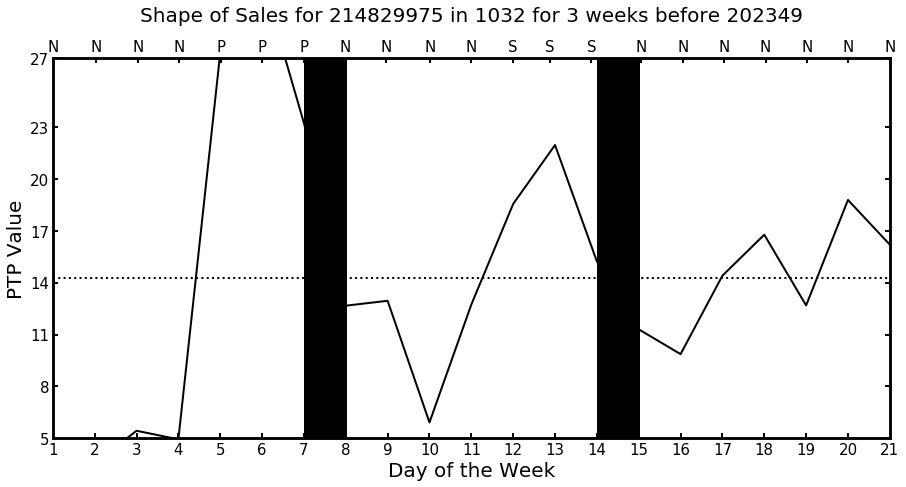

In [10]:
#This code builds a pandas dataframe from the data layer & filters out sales which are invalid (called df)
df = spark.read.orc(data_layer)
df = df.filter(df.year_week_number.isin(week,week2,week3))
df = df.filter(df.base_product_number == bpn)
df = df.filter(df.retail_outlet_number == rot)
df = df.select( df.product_group_division_code,df.product_sub_group_code,df.base_product_number,df.retail_outlet_number,df.year_week_number,df.day_number,df.ptg_value,df.adjusted_sales_singles,df.actual_sales_singles,df.expected_daily_sales_qty,df.wthr_factor,df.step_indicator)
df.createOrReplaceTempView("DATA")
query = """SELECT product_sub_group_code, product_group_division_code, base_product_number, step_indicator,
retail_outlet_number, year_week_number, day_number, Sum(adjusted_sales_singles / Coalesce(wthr_factor,1)) AS sales, 
Sum(Sum(adjusted_sales_singles / Coalesce(wthr_factor,1))) Over(PARTITION BY product_sub_group_code, product_group_division_code,base_product_number, retail_outlet_number,year_week_number) AS Full_Week_Sales, 
Count(Sum(adjusted_sales_singles / Coalesce(wthr_factor,1))) Over(PARTITION BY product_sub_group_code, product_group_division_code,base_product_number, retail_outlet_number,year_week_number) AS Count_Check,
Sum(CASE WHEN step_indicator = 'N' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, product_group_division_code,base_product_number, retail_outlet_number,year_week_number) AS Step_Check_N, 
Sum(CASE WHEN step_indicator = 'S' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, product_group_division_code,base_product_number, retail_outlet_number,year_week_number) AS Step_Check_S, 
Sum(CASE WHEN step_indicator = 'B' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, product_group_division_code,base_product_number, retail_outlet_number,year_week_number) AS Step_Check_B, 
Sum(CASE WHEN step_indicator = 'P' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, product_group_division_code,base_product_number, retail_outlet_number,year_week_number) AS Step_Check_P, 
Sum(CASE WHEN step_indicator = 'M' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, product_group_division_code,base_product_number, retail_outlet_number,year_week_number) AS Step_Check_M  
FROM DATA 
WHERE (adjusted_sales_singles <> expected_daily_sales_qty OR adjusted_sales_singles = actual_sales_singles) 
GROUP BY step_indicator, product_sub_group_code, product_group_division_code,base_product_number,retail_outlet_number,year_week_number,day_number"""
df = spark.sql(query)
df = df.filter(df.Full_Week_Sales > 1)
df = df.filter(df.Count_Check == 7)
#df = df.filter((df.Step_Check_S == 7) | (df.Step_Check_N == 7) | (df.Step_Check_B == 7) | (df.Step_Check_P == 7) | (df.Step_Check_M == 7))
df = df.withColumn("Sales_PTP",((100*(df.sales/df.Full_Week_Sales))))
df = df.toPandas()
df = df.sort_values(by=(['year_week_number','day_number']), ascending=True)
df = df.reset_index(drop=True)
df['ywdn'] = df.index + 1
df['flat'] = 100/7

#This code plots the last 3 weeks of sales data for the chosen product
fig,ax1= plt.subplots(figsize=(15,7))
ax1.plot(df["ywdn"].tolist(),df["Sales_PTP"].tolist(),'b-',ls='-',color='k',lw=2,label='Deweatherised Adjusted Sales')
ax1.plot(df["ywdn"].tolist(),df["flat"].tolist(),'b-',ls=':',color='k',lw=2)
ax1.fill_between([7,8],0,100,color='k')
ax1.fill_between([14,15],0,100,color='k')
ax1.set_xlabel('Day of the Week',fontsize=20)
ax1.set_ylabel('PTP Value',fontsize=20)
ax1.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
ax1.set_yticks([5.0,8.0,11.0,14.0,17.0,20.0,23.0,27.0])
plt.title('Shape of Sales for '+str(bpn)+' in '+str(rot)+' for 3 weeks before '+str(week),fontsize=20,y=1.08)
ax1.set_xlim(1,21)
ax1.set_ylim(5,27)

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_xticks([0.8,1.85,2.85,3.85,4.85,5.85,6.85,7.85,8.85,9.9,10.9,11.9,12.8,13.8,15,16,17,18,19,20,21])
ax2.set_xticklabels(df['step_indicator'].tolist())
plt.show()

ValueError: x and y must have same first dimension, but have shapes (21,) and (0,)

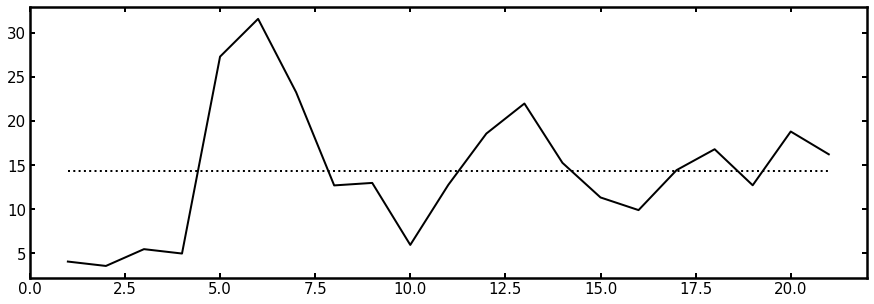

In [11]:
#This code builds a pandas dataframe from the output tables (called df2)
r_dates_df = [output_table3, output_table2, output_table]
r_weeks_df = [week3, week2, week]
d = {}
for i in range(0,len(r_dates_df)):
    ptp_out_path = r_dates_df[i]
    d["data_df_{0}".format(i+1)] = spark.read.csv(ptp_out_path)
    d["data_df_{0}".format(i+1)] = d["data_df_{0}".format(i+1)].drop('_c4')
    d["data_df_{0}".format(i+1)] = d["data_df_{0}".format(i+1)].withColumn("_c4", lit(r_weeks_df[i]))
dfs = []
for i in range(1,len(r_dates_df)+1):   
    dfs.append(d['data_df_'+str(i)])
reactive_df = reduce(DataFrame.unionAll, dfs)
reactive_df.createOrReplaceTempView("DATA")
reactive_df = spark.sql("""SELECT x.base_product_number as bpn, x.retail_outlet_number as ron, 
x.product_sub_group_code as psgc, x.year_week_number_start as ywn, expl.DayoftheWeek as dotw, expl.ptp as R_PTP 
FROM 
(SELECT 
u.retail_outlet_number,u.base_product_number,u.product_sub_group_code,u.year_week_number_start, 
map("1",ptp_1,"2",ptp_2,"3",ptp_3,"4",ptp_4,"5",ptp_5,"6",ptp_6,"7",ptp_7) as ptp_map 
FROM 
(SELECT 
nptp._c0 as retail_outlet_number, nptp._c2 as base_product_number, nptp._c1 as product_sub_group_code, 
nptp._c3 as year_week_number_start, nptp._c7 as ptp_1, nptp._c8 as ptp_2, nptp._c9 as ptp_3, nptp._c10 as ptp_4,
nptp._c11 as ptp_5, nptp._c12 as ptp_6, nptp._c13 as ptp_7 
FROM 
DATA nptp) 
AS u ) 
AS x lateral view explode(ptp_map) expl as DayoftheWeek, ptp""")
reactive_df = reactive_df.filter(reactive_df.ron.isin(str(0)+str(rot)))
reactive_df = reactive_df.filter(reactive_df.bpn.isin(str(bpn)))
reactive_df.createOrReplaceTempView("rptp")
df2 = reactive_df.toPandas()
df2.bpn = df2.bpn.astype(float)
df2.ron = df2.ron.astype(float)
df2.ywn = df2.ywn.astype(float)
df2.dotw = df2.dotw.astype(float)
df2.R_PTP = df2.R_PTP.astype(float)

#This code plots the last 3 weeks of sales data (from df) for the chosen product along with the reactive ptps (from df2)
fig = plt.figure(figsize=(15,5))
plt.plot(df["ywdn"].tolist(),df["Sales_PTP"].tolist(),ls='-',color='k',lw=2,label='Deweatherised Adjusted Sales')
plt.plot(df["ywdn"].tolist(),df["flat"].tolist(),ls=':',color='k',lw=2)
plt.plot(df["ywdn"].tolist(),df2["R_PTP"].tolist(),ls='-',color='blue',lw=2,label='Reactive PTP')
plt.fill_between([7,8],0,100,color='k',zorder=20)
plt.fill_between([14,15],0,100,color='k',zorder=20)
plt.xlabel('Day of the Week',fontsize=20)
plt.ylabel('PTP Value',fontsize=20)
plt.legend(frameon=False,fontsize=12)
plt.title('Shape of Sales for '+str(bpn)+' in '+str(rot)+' for 3 weeks before '+str(week),fontsize=20)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
plt.yticks([5.0,8.0,11.0,14.0,17.0,20.0,23.0,26.0])
plt.xlim(1,21)
plt.ylim(4,27)
plt.show()

#This code builds a pandas dataframe (called df3 which is a joined version of df and df2) and outputs the ptp error
df3 = pd.merge(df,df2,how='inner', left_on = ['base_product_number', 'retail_outlet_number', 'product_sub_group_code','year_week_number','day_number'], right_on = ['bpn','ron','psgc','ywn','dotw'])
df3["R_PTP_Sales"] = ((0.01*df3.R_PTP*df3.Full_Week_Sales))
df3["R_PTP_Sales_Error"] = np.abs((0.01*df3.R_PTP*df3.Full_Week_Sales)-df3.sales)
df3["R_PTP_Sales_Bias"] = (0.01*df3.R_PTP*df3.Full_Week_Sales)-df3.sales
df3["Poisson_Sales"] = 0
df3.loc[df3["sales"] > 0,'Poisson_Sales'] = 0.8*(df3["sales"])**0.5
df3["R_PTP_Sales_Error_No_Noise"] = df3["R_PTP_Sales_Error"] - df3["Poisson_Sales"]
print('Reactive PTP Error for '+str(bpn)+' in '+str(rot)+' is '+str((100*np.sum(df3["R_PTP_Sales_Error_No_Noise"])/np.sum(df3["sales"])).round(2))+'%')

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Check generated PTPs

In [56]:
customSchema = StructType([
    StructField("ro_no",IntegerType(),True),
    StructField("sg_cd", StringType(), True),
    StructField("bpn", IntegerType(), True), 
    StructField("yrwk_start", IntegerType(), True),
    StructField("yrwk_end", IntegerType(), True),
    StructField("PTP_TYPE", StringType(), True),
    StructField("CASCADE_DELETE", StringType(), True),
    StructField("PTP_1", DoubleType(), True),
    StructField("PTP_2", DoubleType(), True),
    StructField("PTP_3", DoubleType(), True),
    StructField("PTP_4", DoubleType(), True),
    StructField("PTP_5", DoubleType(), True),
    StructField("PTP_6", DoubleType(), True),
    StructField("PTP_7", DoubleType(), True),
    StructField("LAST_UPLOAD_USER_ID", StringType(), True)
])

### Check generated PTP for store-product

In [59]:
# Last week generated PTPs based on execution date 
df_ptp = spark.read.format('csv').schema(customSchema).load(output_table3)
df_ptp = df_ptp.filter(df_ptp.bpn == bpn)#.filter(df_ptp.ro_no == rot)
df_ptp.show()

+-----+-----+---------+----------+--------+--------+--------------+-----+-----+-----+-----+-----+-----+-----+-------------------+
|ro_no|sg_cd|      bpn|yrwk_start|yrwk_end|PTP_TYPE|CASCADE_DELETE|PTP_1|PTP_2|PTP_3|PTP_4|PTP_5|PTP_6|PTP_7|LAST_UPLOAD_USER_ID|
+-----+-----+---------+----------+--------+--------+--------------+-----+-----+-----+-----+-----+-----+-----+-------------------+
| 1057|A03EE|212558386|    202403|  202411|       F|             N| 14.4| 14.3| 15.3| 15.0| 15.0| 14.0| 12.0|           PTPONTAP|
| 1015|A03EE|212558386|    202403|  202411|       F|             N| 12.4| 12.0| 12.6| 12.6| 18.1| 19.1| 13.3|           PTPONTAP|
| 1121|A03EE|212558386|    202403|  202411|       F|             N| 13.9| 14.4| 14.1| 14.9| 15.3| 15.2| 12.1|           PTPONTAP|
| 4029|A03EE|212558386|    202403|  202411|       F|             N| 16.1| 15.5| 15.6| 15.4| 13.8| 11.9| 11.6|           PTPONTAP|
| 4001|A03EE|212558386|    202403|  202411|       F|             N| 14.6| 13.9| 14.2| 14.3

In [60]:
df_ptp = df_ptp.toPandas()
df_ptp.to_csv('control_ptp.csv',index=True)

### Check generated PTP for store-sg_cd

In [ ]:
# Last week generated PTPs based on execution date
sgcd = 'B40BB'
store = 4047
df_ptp = spark.read.csv(output_table)
df_ptp = df_ptp.filter(df_ptp._c1==sgcd)
df_ptp = df_ptp.filter(df_ptp._c2==0)
df_ptp = df_ptp.filter(substring('_c0',2,4)==store)
df_ptp.show()

In [ ]:
# Last week generated PTPs based on execution date
df_ptp = spark.read.csv(output_table)
df_ptp = df_ptp.filter(df_ptp._c2==0)
dfsgcd = df_ptp.toPandas()
dfsgcd.shape

In [38]:
dfsgcd.to_csv('CZ_sgcd_5th_20230124.csv',index=False)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Analaysis - new store & check sim id assignment

### Check distinct sim_ids for store

In [49]:
!hdfs dfs -ls '/insight_prod/rdf_archive/hive_tables/reactive_ptp/store_department/country=sk' | tail -n 1

drwx------   - svc-rdf-true-prod hdfs          0 2024-03-05 03:39 /insight_prod/rdf_archive/hive_tables/reactive_ptp/store_department/country=sk/year_week=202402


In [14]:
yrwk = '202402'

#### Store assignment

In [15]:
simid_store_new = spark.read.orc(store_lookup).filter('year_week = {}'.format(yrwk)) 
simid_store_new = simid_store_new.drop('product_sub_group_code')
simid_store_new = simid_store_new.distinct()
simid_store_new.show()

+------+--------------------------------+--------------------+-------------------------------------+---------+
|sim_id|store_custom_cluster_description|retail_outlet_number|department_custom_cluster_description|year_week|
+------+--------------------------------+--------------------+-------------------------------------+---------+
|    16|                 small_cluster_1|                4153|                   subgroup_cluster_4|   202402|
|     1|                      all_stores|                4030|                            Hardlines|   202402|
|    13|                 small_cluster_0|                4070|                   subgroup_cluster_5|   202402|
|     1|                      all_stores|                7009|                            Hardlines|   202402|
|    17|                 small_cluster_1|                4040|                   subgroup_cluster_5|   202402|
|     8|                 large_cluster_1|                1002|                   subgroup_cluster_4|   202402|
|

In [22]:
store_dep = simid_store_new.join(store_all, store_all.branch_number == simid_store_new.retail_outlet_number, 'left')
store_dep = store_dep.selectExpr('sim_id', '"SKDB" as db', 'store_custom_cluster_description', 'department_custom_cluster_description','store_format_code', '"SK" as country_code').distinct()
store_dep = store_dep.orderBy('store_format_code', 'sim_id')\
                     .filter('store_format_code IS NOT NULL')\
                     .show(100, False)

+------+----+--------------------------------+-------------------------------------+-----------------+------------+
|sim_id|db  |store_custom_cluster_description|department_custom_cluster_description|store_format_code|country_code|
+------+----+--------------------------------+-------------------------------------+-----------------+------------+
|1     |SKDB|all_stores                      |Hardlines                            |Expres           |SK          |
|5     |SKDB|large_cluster_0                 |subgroup_cluster_5                   |Expres           |SK          |
|6     |SKDB|large_cluster_1                 |subgroup_cluster_0                   |Expres           |SK          |
|7     |SKDB|large_cluster_1                 |subgroup_cluster_3                   |Expres           |SK          |
|8     |SKDB|large_cluster_1                 |subgroup_cluster_4                   |Expres           |SK          |
|9     |SKDB|large_cluster_1                 |subgroup_cluster_5        

In [45]:
simid_store_new_pd = simid_store_new.toPandas()
simid_store_new_pd.to_csv('store_simids.csv',index=False)

#### Sg_cd assignment

In [46]:
sg_cd = 'A03EE'
simid_store_new2 = spark.read.orc(store_lookup).filter('year_week = {}'.format(yrwk)).filter("product_sub_group_code = '{}'".format(sg_cd))
simid_store_new2.show()

+------+--------------------------------+--------------------+-------------------------------------+----------------------+---------+
|sim_id|store_custom_cluster_description|retail_outlet_number|department_custom_cluster_description|product_sub_group_code|year_week|
+------+--------------------------------+--------------------+-------------------------------------+----------------------+---------+
|    10|                 small_cluster_0|                4156|                   subgroup_cluster_0|                 A03EE|   202316|
|     6|                 large_cluster_1|                6704|                   subgroup_cluster_0|                 A03EE|   202316|
|     6|                 large_cluster_1|                6707|                   subgroup_cluster_0|                 A03EE|   202316|
|    14|                 small_cluster_1|                7006|                   subgroup_cluster_0|                 A03EE|   202316|
|    14|                 small_cluster_1|                7008|

In [47]:
simid_store_new2_pd = simid_store_new2.toPandas()
simid_store_new2_pd.to_csv('A03EE_simids.csv',index=False)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Analysis - store-product combination - adjusted sales & PTP

### Check sim_id for store-product combination

In [14]:
simid_store = spark.read.orc(splist)
simid_store.cache()
simid_store = simid_store.filter((simid_store.retail_outlet_number == rot)&(simid_store.base_product_number == bpn))
simid_store.show()

+--------------------+-------------------+------+
|retail_outlet_number|base_product_number|sim_id|
+--------------------+-------------------+------+
|                1008|          220216782|     8|
+--------------------+-------------------+------+



In [15]:
simid = simid_store.select('sim_id').collect()[0]
simid_var = simid['sim_id']
print(simid_var)

8


### Check exponential sales and ptp for store-product combination

In [ ]:
sales = spark.read.orc(data_table)
sales_filtered = sales.filter((sales.retail_outlet_number == rot)&(sales.base_product_number == bpn)&(sales.execution_date == ow))
sales_filtered.cache()
windowSpecAgg = Window.partitionBy('base_product_number')
sales_filtered = sales_filtered.withColumn("sum_adjusted_sales", sum(col("adjusted_sales")).over(windowSpecAgg)) 
sales_filtered = sales_filtered.withColumn('ptp',round((sales_filtered.adjusted_sales/sales_filtered.sum_adjusted_sales*100),2)).orderBy(col('day_number').asc(),col('execution_date').desc())

sales_filtered.show()
sales_filtered.unpersist()

### Check used exponential sales & PTP for product for all stores in store-product sim_id

In [ ]:
sales = spark.read.orc(data_table)
sales_filtered_bpn = sales.filter((sales.base_product_number == bpn)&(sales.sim_id == simid_var)&(sales.execution_date == ow))
sales_filtered_bpn.cache()
sales_filtered_bpn =sales_filtered_bpn.groupBy('sim_id','base_product_number','day_number').agg(sum('adjusted_sales').alias('adj_sales'))
windowSpecAgg = Window.partitionBy()
sales_filtered_bpn = sales_filtered_bpn.withColumn("sum_adjusted_sales", sum(col("adj_sales")).over(windowSpecAgg)) 
sales_filtered_bpn = sales_filtered_bpn.withColumn('ptp',round((sales_filtered_bpn.adj_sales/sales_filtered_bpn.sum_adjusted_sales*100),2)).orderBy('day_number')

sales_filtered_bpn.show()
sales_filtered_bpn.unpersist()

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# Analysis of valid days for store-product combination

In [30]:
cal = spark.sql("""SELECT CAST(b.calendar_date AS DATE) as calendar_date
                ,b.year_week_number as tesco_yrwk
                ,b.day_number as day
                ,b.day_text 
                ,lw.calendar_date as lw_calendar_date
                ,lw.year_week_number as lw_tesco_yrwk
                ,lw.day_number as lw_day
                ,lw.day_text as lw_day_text
                FROM lookup.calendar as b 
                
                INNER JOIN lookup.calendar as lw
                ON DATE_SUB(lw.calendar_date,-7) = b.calendar_date
                
                WHERE b.calendar_date > '2021-01-01'""")

cal_yrwk = cal.filter(cal.day == 1).select(cal.calendar_date,cal.tesco_yrwk,cal.lw_calendar_date,cal.lw_tesco_yrwk)

### Ensemble PTP

In [31]:
ensembledf = spark.read.orc(ensemble_path)\
            .filter((col('Base_Product_Number') == bpn)&(col('execution_date') == ow)&(col('location_id') == rot_id))
ensembledf = ensembledf.orderBy(ensembledf.execution_date.asc(),ensembledf.Day.asc())
ensembledf = ensembledf.withColumn('Retail_Outlet_Number',lit(rot))
ensembledf = ensembledf.withColumn('Reactive_PTP',round(ensembledf.Reactive_PTP*100,1))
ensembledf = ensembledf.withColumn('Sphist_PTP',round(ensembledf.Sphist_PTP*100,1))
ensembledf = ensembledf.withColumn('Subgroup_Sphist_PTP',round(ensembledf.Subgroup_Sphist_PTP*100,1))
ensembledf = ensembledf.withColumn("PTP",round(ensembledf.PTP*100,1))
ensembledf = ensembledf.withColumn('execution_date',ensembledf.execution_date.cast("date"))
ensembledf = ensembledf.join(cal.select(cal.calendar_date,cal.tesco_yrwk,cal.day),on=((ensembledf.execution_date == cal.calendar_date)),how='left').select(ensembledf['*'],cal.tesco_yrwk)
ensembledf = ensembledf.orderBy(ensembledf.tesco_yrwk.asc(),ensembledf.Day.asc())
ensemble_g = ensembledf.toPandas()

#Prep for transformation
ensemble_pivot = ensembledf.toPandas()
ensembledf.unpersist()

#Transformations 
ensemble_pivot1 = ensemble_pivot.pivot_table(index=['execution_date','sim_id','Retail_Outlet_Number','Base_Product_Number','product_sub_group_code','tesco_yrwk','base_product_number_weekly_exponential_sales','Reactive_PTP_weightage','Sphist_PTP_weightage','Subgroup_Sphist_PTP_weightage'],columns='Day',values=['Reactive_PTP','Sphist_PTP','Subgroup_Sphist_PTP','PTP']).reset_index()
ensemble_pivot1.columns = [f"{first}-{second}" if second else first for first,second in ensemble_pivot1.columns]
df_melted = pd.melt(ensemble_pivot1, id_vars=['execution_date', 'sim_id', 'Retail_Outlet_Number', 'Base_Product_Number', 'product_sub_group_code', 'base_product_number_weekly_exponential_sales', 'Reactive_PTP_weightage', 'Sphist_PTP_weightage', 'Subgroup_Sphist_PTP_weightage', 'tesco_yrwk'], var_name='Variable_Day', value_name='Value')
df_melted[['Variable','Day']] = df_melted['Variable_Day'].str.split('-',expand=True)
df_melted.drop(columns='Variable_Day',inplace=True)
df_melted.reset_index()
df_transformed = df_melted.pivot_table(index=['execution_date','sim_id','Retail_Outlet_Number','Base_Product_Number','product_sub_group_code','base_product_number_weekly_exponential_sales','Reactive_PTP_weightage','Sphist_PTP_weightage','Subgroup_Sphist_PTP_weightage','tesco_yrwk','Variable'],columns='Day',values='Value').reset_index().rename_axis(None,axis=1)
df_transformed.sort_values(by=['tesco_yrwk'],ascending=False,inplace=True)
df_transformed.rename(columns={'base_product_number_weekly_exponential_sales':'weekly_exponential_sales','Retail_Outlet_Number':'Store','Base_Product_Number':'TPNB','product_sub_group_code':'SG_CD'},inplace=True)
df_transformed.head(15)

,execution_date,sim_id,Store,TPNB,SG_CD,weekly_exponential_sales,Reactive_PTP_weightage,Sphist_PTP_weightage,Subgroup_Sphist_PTP_weightage,tesco_yrwk,Variable,1,2,3,4,5,6,7
0,2024-04-15,9,1001,121517870,A36BF,12.889886,0.728633,0.121367,0.15,202408,PTP,8.0,7.3,9.9,10.8,22.3,26.6,15.2
1,2024-04-15,9,1001,121517870,A36BF,12.889886,0.728633,0.121367,0.15,202408,Reactive_PTP,8.3,8.7,10.1,11.2,22.4,25.7,13.6
2,2024-04-15,9,1001,121517870,A36BF,12.889886,0.728633,0.121367,0.15,202408,Sphist_PTP,8.9,3.0,8.9,9.0,19.2,29.0,22.0
3,2024-04-15,9,1001,121517870,A36BF,12.889886,0.728633,0.121367,0.15,202408,Subgroup_Sphist_PTP,5.8,3.5,9.9,10.1,24.3,28.9,17.5


### Base SPHIst

In [32]:
base_sphist = spark.read.orc(sphist)
base_sphist = base_sphist.filter(base_sphist.base_product_number == bpn).filter(base_sphist.location_id == rot_id)
base_sphist = base_sphist.withColumn('retail_outlet_number',lit(rot))
base_sphist = base_sphist.withColumn('execution_date',lit(ow))
base_sphist.cache()
base_sphist = base_sphist.withColumnRenamed('year_week_number','tesco_yrwk_ModelRun')
base_sphist = base_sphist.join(cal_yrwk,[base_sphist.tesco_yrwk_ModelRun == cal_yrwk.tesco_yrwk],'left').select(base_sphist['*'],cal_yrwk.lw_tesco_yrwk.alias('tesco_yrwk'))
valid_pd = base_sphist.toPandas()
base_sphist.unpersist()

DataFrame[location_id: string, base_product_number: int, tesco_yrwk_ModelRun: int, num_valid: bigint, sum_sales: double, daily_sales: array<struct<day_number:int,valid:int,valid_sales:double,previous_sales:double,adjusted_sales:double,seed_nws:double,final_nws:double,step_change_indicator:string>>, product_sub_group_code: string, sim_id: int, retail_outlet_number: int, execution_date: string, tesco_yrwk: int]

#### Exponential sales & SPHist Product PTP Overview

In [33]:
df_exponential_sales = valid_pd.copy()
df_exponential_sales.drop(columns='location_id',inplace=True)
df = pd.DataFrame([pd.Series(x) for x in valid_pd.daily_sales])
df_exponential_sales.sort_values(by='tesco_yrwk_ModelRun',ascending=False,inplace=True)
df_exponential_sales['mon_exponential_sales'] = df[0].str[4]
df_exponential_sales['tue_exponential_sales'] = df[1].str[4]
df_exponential_sales['wed_exponential_sales'] = df[2].str[4]
df_exponential_sales['thu_exponential_sales'] = df[3].str[4]
df_exponential_sales['fri_exponential_sales'] = df[4].str[4]
df_exponential_sales['sat_exponential_sales'] = df[5].str[4]
df_exponential_sales['sun_exponential_sales'] = df[6].str[4]
df_exponential_sales['mon_ptp'] = np.round(df_exponential_sales['mon_exponential_sales']/(df_exponential_sales['mon_exponential_sales']+df_exponential_sales['tue_exponential_sales']+df_exponential_sales['wed_exponential_sales']+df_exponential_sales['thu_exponential_sales']+df_exponential_sales['fri_exponential_sales']+df_exponential_sales['sat_exponential_sales']+df_exponential_sales['sun_exponential_sales'])*100,1)
df_exponential_sales['tue_ptp'] = np.round(df_exponential_sales['tue_exponential_sales']/(df_exponential_sales['mon_exponential_sales']+df_exponential_sales['tue_exponential_sales']+df_exponential_sales['wed_exponential_sales']+df_exponential_sales['thu_exponential_sales']+df_exponential_sales['fri_exponential_sales']+df_exponential_sales['sat_exponential_sales']+df_exponential_sales['sun_exponential_sales'])*100,1)
df_exponential_sales['wed_ptp'] = np.round(df_exponential_sales['wed_exponential_sales']/(df_exponential_sales['mon_exponential_sales']+df_exponential_sales['tue_exponential_sales']+df_exponential_sales['wed_exponential_sales']+df_exponential_sales['thu_exponential_sales']+df_exponential_sales['fri_exponential_sales']+df_exponential_sales['sat_exponential_sales']+df_exponential_sales['sun_exponential_sales'])*100,1)
df_exponential_sales['thuy_ptp'] = np.round(df_exponential_sales['thu_exponential_sales']/(df_exponential_sales['mon_exponential_sales']+df_exponential_sales['tue_exponential_sales']+df_exponential_sales['wed_exponential_sales']+df_exponential_sales['thu_exponential_sales']+df_exponential_sales['fri_exponential_sales']+df_exponential_sales['sat_exponential_sales']+df_exponential_sales['sun_exponential_sales'])*100,1)
df_exponential_sales['fri_ptp'] = np.round(df_exponential_sales['fri_exponential_sales']/(df_exponential_sales['mon_exponential_sales']+df_exponential_sales['tue_exponential_sales']+df_exponential_sales['wed_exponential_sales']+df_exponential_sales['thu_exponential_sales']+df_exponential_sales['fri_exponential_sales']+df_exponential_sales['sat_exponential_sales']+df_exponential_sales['sun_exponential_sales'])*100,1)
df_exponential_sales['sat_ptp'] = np.round(df_exponential_sales['sat_exponential_sales']/(df_exponential_sales['mon_exponential_sales']+df_exponential_sales['tue_exponential_sales']+df_exponential_sales['wed_exponential_sales']+df_exponential_sales['thu_exponential_sales']+df_exponential_sales['fri_exponential_sales']+df_exponential_sales['sat_exponential_sales']+df_exponential_sales['sun_exponential_sales'])*100,1)
df_exponential_sales['sun_ptp'] = np.round(df_exponential_sales['sun_exponential_sales']/(df_exponential_sales['mon_exponential_sales']+df_exponential_sales['tue_exponential_sales']+df_exponential_sales['wed_exponential_sales']+df_exponential_sales['thu_exponential_sales']+df_exponential_sales['fri_exponential_sales']+df_exponential_sales['sat_exponential_sales']+df_exponential_sales['sun_exponential_sales'])*100,1)
df_exponential_sales = df_exponential_sales.drop(columns=['daily_sales'])
df_exponential_sales.head(21)

,base_product_number,tesco_yrwk_ModelRun,num_valid,sum_sales,product_sub_group_code,sim_id,retail_outlet_number,execution_date,tesco_yrwk,mon_exponential_sales,tue_exponential_sales,wed_exponential_sales,thu_exponential_sales,fri_exponential_sales,sat_exponential_sales,sun_exponential_sales,mon_ptp,tue_ptp,wed_ptp,thuy_ptp,fri_ptp,sat_ptp,sun_ptp
32,121517870,202408,7,20.747925,A36BF,9,1001,2024-04-15,202407,1.143507,0.383248,1.149467,1.156297,2.476020,3.740969,2.840379,8.9,3.0,8.9,9.0,19.2,29.0,22.0
11,121517870,202405,7,8.987230,A36BF,9,1001,2024-04-15,202404,1.174638,0.547496,1.200269,0.749597,1.766216,2.388459,1.695480,12.3,5.7,12.6,7.9,18.5,25.1,17.8
5,121517870,202404,7,11.576568,A36BF,9,1001,2024-04-15,202403,1.265967,0.357810,1.286098,1.070853,2.523165,2.178785,1.068731,13.0,3.7,13.2,11.0,25.9,22.3,11.0
4,121517870,202403,7,6.613750,A36BF,9,1001,2024-04-15,202402,0.737096,0.511157,1.296562,0.714257,2.896139,1.707398,1.106590,8.2,5.7,14.5,8.0,32.3,19.0,12.3
24,121517870,202402,2,3.220905,A36BF,9,1001,2024-04-15,202401,1.052994,0.730224,0.683401,1.020367,3.871148,1.863876,0.756667,10.6,7.3,6.8,10.2,38.8,18.7,7.6
23,121517870,202401,7,5.582942,A36BF,9,1001,2024-04-15,202352,0.366476,0.800589,0.683401,1.020367,3.871148,1.863876,0.756667,3.9,8.6,7.3,10.9,41.3,19.9,8.1
12,121517870,202352,0,0.000000,A36BF,9,1001,2024-04-15,202351,0.523538,1.143699,0.976287,1.457667,3.516788,2.662680,0.701686,4.8,10.4,8.9,13.3,32.0,24.2,6.4
33,121517870,202351,0,0.000000,A36BF,9,1001,2024-04-15,202350,0.523538,1.143699,0.976287,1.457667,3.516788,2.662680,0.701686,4.8,10.4,8.9,13.3,32.0,24.2,6.4
18,121517870,202349,7,9.646465,A36BF,9,1001,2024-04-15,202348,0.523538,1.143699,0.976287,1.457667,3.516788,2.662680,0.701686,4.8,10.4,8.9,13.3,32.0,24.2,6.4
3,121517870,202338,7,7.560528,A36BF,9,1001,2024-04-15,202337,0.747911,1.633856,1.394695,1.844285,2.241052,2.690655,1.002409,6.5,14.1,12.1,16.0,19.4,23.3,8.7


#### Sphist valid sales vs Data Layer Adj sales overview

In [34]:
df = pd.DataFrame([pd.Series(x) for x in valid_pd.daily_sales])
df_adj_sales = valid_pd.copy()
df_adj_sales.drop(columns='location_id',inplace=True)
df_adj_sales['valid_sal_1'] = df[0].str[2].round(2)
df_adj_sales['valid_sal_2'] = df[1].str[2].round(2)
df_adj_sales['valid_sal_3'] = df[2].str[2].round(2)
df_adj_sales['valid_sal_4'] = df[3].str[2].round(2)
df_adj_sales['valid_sal_5'] = df[4].str[2].round(2)
df_adj_sales['valid_sal_6'] = df[5].str[2].round(2)
df_adj_sales['valid_sal_7'] = df[6].str[2].round(2)
df_adj_sales = df_adj_sales.drop(columns=['daily_sales'])
df_adj_sales.sort_values('tesco_yrwk_ModelRun',ascending=False,inplace=True)

#DataLayer connection
dataLayer = spark.read.orc(data_layer)
dataLayer = dataLayer.filter(dataLayer.base_product_number == bpn).filter(dataLayer.location_id == rot_id)
dataLayer = dataLayer.withColumn('retail_outlet_number',lit(rot))
dataLayer = dataLayer.select(dataLayer.base_product_number,dataLayer.retail_outlet_number,dataLayer.calendar_date,dataLayer.year_week_number,dataLayer.day_number,dataLayer.adjusted_sales_singles,dataLayer.wthr_factor)
dataLayer = dataLayer.withColumnRenamed('year_week_number','tesco_yrwk').withColumnRenamed('adjusted_sales_singles','adj_sal').withColumnRenamed('wthr_factor','wf')
dataLayer = dataLayer.toPandas()
dataLayer = pd.pivot_table(dataLayer,index=['base_product_number','retail_outlet_number','tesco_yrwk'],columns=['day_number'],values=['adj_sal','wf'], aggfunc='first').reset_index()
dataLayer.columns = [f"{first}_{second}" if second else first for first, second in dataLayer.columns]

#Merging
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_adj_sales = df_adj_sales.merge(dataLayer,on=['retail_outlet_number','base_product_number','tesco_yrwk'],how='left')
df_adj_sales.head(21)

,base_product_number,tesco_yrwk_ModelRun,num_valid,sum_sales,product_sub_group_code,sim_id,retail_outlet_number,execution_date,tesco_yrwk,valid_sal_1,valid_sal_2,valid_sal_3,valid_sal_4,valid_sal_5,valid_sal_6,valid_sal_7,adj_sal_1,adj_sal_2,adj_sal_3,adj_sal_4,adj_sal_5,adj_sal_6,adj_sal_7,wf_1,wf_2,wf_3,wf_4,wf_5,wf_6,wf_7
0,121517870,202408,7,20.747925,A36BF,9,1001,2024-04-15,202407,1.07,0.00,1.03,2.11,4.13,6.90,5.51,1.36,0.00,1.00,2.00,5.00,8.69,7.00,1.27,1.24,0.97,0.95,1.21,1.26,1.27
1,121517870,202405,7,8.987230,A36BF,9,1001,2024-04-15,202404,0.96,0.99,1.00,0.00,0.00,2.88,3.16,1.00,1.00,1.00,0.00,0.00,4.00,3.00,1.04,1.01,1.00,0.97,1.29,1.39,0.95
2,121517870,202404,7,11.576568,A36BF,9,1001,2024-04-15,202403,2.50,0.00,1.26,1.90,1.65,3.28,0.98,3.00,0.00,1.35,1.96,2.00,4.00,1.00,1.20,1.28,1.07,1.03,1.21,1.22,1.02
3,121517870,202403,7,6.613750,A36BF,9,1001,2024-04-15,202402,0.00,0.00,2.73,0.00,0.62,1.34,1.92,0.00,0.00,3.00,0.00,1.00,2.00,2.00,1.03,1.19,1.10,1.31,1.61,1.49,1.04
4,121517870,202402,2,3.220905,A36BF,9,1001,2024-04-15,202401,2.65,0.57,0.00,0.00,0.00,0.00,0.00,3.00,0.60,1.00,1.00,3.00,1.00,1.00,1.13,1.06,1.07,1.10,1.31,1.45,1.08
5,121517870,202401,7,5.582942,A36BF,9,1001,2024-04-15,202352,0.00,0.00,0.00,0.00,4.70,0.00,0.88,0.00,0.00,0.00,0.00,7.00,0.00,1.00,0.94,0.92,0.91,1.11,1.49,1.45,1.13
6,121517870,202352,0,0.000000,A36BF,9,1001,2024-04-15,202351,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,2.00,2.00,0.00,1.00,2.00,0.92,0.92,0.91,0.86,0.76,0.71,0.89
7,121517870,202351,0,0.000000,A36BF,9,1001,2024-04-15,202350,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,3.00,0.00,0.93,0.92,0.90,0.87,0.80,1.01,0.88
8,121517870,202349,7,9.646465,A36BF,9,1001,2024-04-15,202348,0.00,0.00,0.00,0.56,6.49,2.60,0.00,0.00,0.00,0.00,0.50,5.00,2.00,0.00,0.96,0.94,0.93,0.90,0.77,0.77,0.89
9,121517870,202338,7,7.560528,A36BF,9,1001,2024-04-15,202337,0.81,2.42,0.82,1.63,0.00,1.02,0.86,1.00,3.00,1.00,2.00,0.00,1.00,1.00,1.23,1.24,1.22,1.23,1.00,0.98,1.16


#### Step change & NWS overview

In [35]:
df = pd.DataFrame([pd.Series(x) for x in valid_pd.daily_sales])
df_adj_sales = valid_pd.copy()
df_adj_sales.drop(columns=['daily_sales','execution_date','location_id'],inplace=True)
df_adj_sales['1_step_change'] = df[0].str[7]
df_adj_sales['2_step_change'] = df[1].str[7]
df_adj_sales['3_step_change'] = df[2].str[7]
df_adj_sales['4_step_change'] = df[3].str[7]
df_adj_sales['5_step_change'] = df[4].str[7]
df_adj_sales['6_step_change'] = df[5].str[7]
df_adj_sales['7_step_change'] = df[6].str[7]
df_adj_sales['1_seedNWS'] = df[0].str[5].round(2)
df_adj_sales['2_seedNWS'] = df[1].str[5].round(2)
df_adj_sales['3_seedNWS'] = df[2].str[5].round(2)
df_adj_sales['4_seedNWS'] = df[3].str[5].round(2)
df_adj_sales['5_seedNWS'] = df[4].str[5].round(2)
df_adj_sales['6_seedNWS'] = df[5].str[5].round(2)
df_adj_sales['7_seedNWS'] = df[6].str[5].round(2)
df_adj_sales['1_finalNWS'] = df[0].str[6].round(2)
df_adj_sales['2_finalNWS'] = df[1].str[6].round(2)
df_adj_sales['3_finalNWS'] = df[2].str[6].round(2)
df_adj_sales['4_finalNWS'] = df[3].str[6].round(2)
df_adj_sales['5_finalNWS'] = df[4].str[6].round(2)
df_adj_sales['6_finalNWS'] = df[5].str[6].round(2)
df_adj_sales['7_finalNWS'] = df[6].str[6].round(2)

# Melt the DataFrame to convert it from wide to long format
melted1_df = pd.melt(df_adj_sales, id_vars=['base_product_number','retail_outlet_number','tesco_yrwk_ModelRun','num_valid','sum_sales','tesco_yrwk'], value_vars=['1_step_change', '2_step_change', '3_step_change', '4_step_change', '5_step_change', '6_step_change', '7_step_change'], var_name='weekday', value_name='step_change')
melted1_df['weekday'] = melted1_df['weekday'].str[:1].astype(int)
melted2_df = pd.melt(df_adj_sales, id_vars=['base_product_number','retail_outlet_number','tesco_yrwk_ModelRun','num_valid','sum_sales','tesco_yrwk'], value_vars=['1_seedNWS', '2_seedNWS', '3_seedNWS', '4_seedNWS', '5_seedNWS', '6_seedNWS', '7_seedNWS'], var_name='weekday', value_name='seedNWS')
melted2_df['weekday'] = melted2_df['weekday'].str[:1].astype(int)
melted3_df = pd.melt(df_adj_sales, id_vars=['base_product_number','retail_outlet_number','tesco_yrwk_ModelRun','num_valid','sum_sales','tesco_yrwk'], value_vars=['1_finalNWS', '2_finalNWS', '3_finalNWS', '4_finalNWS', '5_finalNWS', '6_finalNWS', '7_finalNWS'], var_name='weekday', value_name='finalNWS')
melted3_df['weekday'] = melted3_df['weekday'].str[:1].astype(int)

melted_all = melted1_df.merge(melted2_df[['base_product_number','retail_outlet_number','tesco_yrwk','weekday','seedNWS']],on=['base_product_number','retail_outlet_number','tesco_yrwk','weekday'],how='inner')
melted_all = melted_all.merge(melted3_df[['base_product_number','retail_outlet_number','tesco_yrwk','weekday','finalNWS']],on=['base_product_number','retail_outlet_number','tesco_yrwk','weekday'],how='inner')
melted_all.sort_values(by=['tesco_yrwk','weekday'],ascending=[False,True],inplace=True)
melted_all['nws_change'] = ((melted_all['seedNWS']-melted_all['finalNWS'])/melted_all['finalNWS'])\
                            .round(3)\
                            .map(lambda x: '{:.2%}'.format(x))

wide_df = melted_all.pivot_table(index=['base_product_number', 'retail_outlet_number', 'tesco_yrwk_ModelRun', 'num_valid', 'sum_sales', 'tesco_yrwk'],
                                 columns='weekday',
                                 values='nws_change',
                                 aggfunc='first')

# Reset index to make it flat
wide_df.reset_index(inplace=True)
wide_df.sort_values(by='tesco_yrwk',ascending=False,inplace=True)
wide_df.columns = ['base_product_number', 'retail_outlet_number', 'tesco_yrwk_ModelRun', 'num_valid', 'sum_sales', 'tesco_yrwk','MON_stepchange_%','TUE_stepchange_%','WED_stepchange_%','THU_stepchange_%','FRI_stepchange_%','SAT_stepchange_%','SUN_stepchange_%']

df_adj_sales.sort_values(by='tesco_yrwk',ascending=False,inplace=True)
# Apply color formatting to specific columns
df_adj_sales_f = df_adj_sales.style.applymap(lambda x: 'color: blue', subset=[col for col in df_adj_sales.columns if col[2:] in ['seedNWS','finalNWS']])
df_adj_sales_f

,base_product_number,tesco_yrwk_ModelRun,num_valid,sum_sales,product_sub_group_code,sim_id,retail_outlet_number,tesco_yrwk,1_step_change,2_step_change,3_step_change,4_step_change,5_step_change,6_step_change,7_step_change,1_seedNWS,2_seedNWS,3_seedNWS,4_seedNWS,5_seedNWS,6_seedNWS,7_seedNWS,1_finalNWS,2_finalNWS,3_finalNWS,4_finalNWS,5_finalNWS,6_finalNWS,7_finalNWS
32,121517870,202408,7,20.7479,A36BF,9,1001,202407,N,N,N,N,N,N,N,9.97,9.78,10.12,9.84,9.96,11.03,12.84,9.78,10.12,9.84,9.96,11.03,12.84,15.45
11,121517870,202405,7,8.98723,A36BF,9,1001,202404,N,N,S,S,S,S,S,7.08,7.23,7.31,7.31,7.31,7.31,7.31,7.23,7.24,7.73,7.17,7.74,7.56,7.42
5,121517870,202404,7,11.5766,A36BF,9,1001,202403,N,N,N,N,N,N,N,5.6,7.42,7.09,7.35,7.35,6.52,6.87,7.42,7.09,7.35,7.35,6.52,6.87,7.08
4,121517870,202403,7,6.61375,A36BF,9,1001,202402,S,N,N,N,N,N,N,6,6.02,6.01,6.08,5.84,5.34,4.97,6.02,6.01,6.08,5.84,5.34,4.97,5.6
24,121517870,202402,2,3.2209,A36BF,9,1001,202401,N,N,N,S,N,N,N,6.4,8.26,8.17,7,7.04,7.03,0,8.26,8.17,8.15,7.04,7.03,6.99,0
23,121517870,202401,7,5.58294,A36BF,9,1001,202352,N,N,N,S,N,N,N,9.63,9.66,9.71,7.08,7.04,7.21,6.22,9.66,9.71,9.32,7.04,7.21,6.22,6.4
12,121517870,202352,0,0,A36BF,9,1001,202351,S,E,N,N,N,N,N,10.61,9.65,9.66,0,9.67,9.66,9.66,10.61,9.66,9.68,0,9.66,9.66,9.63
33,121517870,202351,0,0,A36BF,9,1001,202350,N,N,N,N,N,S,S,0,9.62,9.62,9.64,9.64,10.61,11.58,0,9.62,9.64,9.64,9.65,10.61,11.58
18,121517870,202349,7,9.64646,A36BF,9,1001,202348,M,M,E,N,N,N,N,10.22,10.32,9.61,9.7,9.78,9.71,9.58,10.32,10.21,9.7,9.78,9.71,9.58,9.63
3,121517870,202338,7,7.56053,A36BF,9,1001,202337,N,N,N,N,N,N,N,9.48,9.69,10.98,10.69,10.81,10.04,9.47,9.69,10.98,10.69,10.81,10.04,9.47,9.61


#### Step ind overview

In [36]:
#Extracting step_ind data from data_layer table
df_ind = spark.read.orc(data_layer)
df_ind = df_ind.filter(df_ind.base_product_number == bpn).filter(df_ind.location_id == rot_id)
df_ind = df_ind.withColumn('retail_outlet_number',lit(rot))
df_ind = df_ind.select(df_ind.product_sub_group_code,df_ind.base_product_number,df_ind.retail_outlet_number,df_ind.calendar_date,df_ind.year_week_number,df_ind.day_text,df_ind.day_number,df_ind.ptp_value,df_ind.ptg_value,df_ind.adjusted_sales_singles,df_ind.actual_sales_singles,df_ind.expected_daily_sales_qty,df_ind.step_indicator,df_ind.wthr_factor)
df_ind.cache()
df_ind = df_ind.withColumn('ptp_type',when(df_ind.ptg_value.isNotNull(),'userPTG').otherwise('systemPTP'))
df_ind = df_ind.withColumnRenamed('year_week_number','tesco_yrwk')
df_indp = df_ind.toPandas()
df_indp['calendar_date_fw'] = df_indp['calendar_date'].astype('datetime64[ns]') + pd.to_timedelta(7,unit='d')
querycal = "SELECT calendar_date,year_week_number as reactive_next_week FROM lookup.calendar"
cal = spark.sql(querycal)       
cal = cal.toPandas()
cal['calendar_date'] = cal['calendar_date'].astype('datetime64[ns]')
df_indp = df_indp.merge(cal,how='inner',left_on='calendar_date_fw', right_on='calendar_date',suffixes=('_left', '_right'))
df_ind_l = pd.pivot_table(df_indp,index=['base_product_number','retail_outlet_number','tesco_yrwk','reactive_next_week'],columns=['day_text'],values=['step_indicator'], aggfunc='first')
df_ind_l.columns = df_ind_l.columns.droplevel()
df_ind_l = df_ind_l.reset_index()
df_ind_l.columns = df_ind_l.columns.str.replace(' ', '')
dict_day = {'MONDAY':'MON_stepind','TUESDAY':'TUE_stepind','WEDNESDAY':'WED_stepind','THURSDAY':'THU_stepind','FRIDAY':'FRI_stepind','SATURDAY':'SAT_stepind','SUNDAY':'SUN_stepind'}
df_ind_l = df_ind_l.rename(dict_day,axis='columns')

df_ind.unpersist()
#Sorting data + connecting step_ind information
valid_pd = valid_pd.sort_values('tesco_yrwk_ModelRun',ascending=False).reset_index(drop=True)
valid_pd_l = valid_pd.merge(df_ind_l[['MON_stepind','TUE_stepind','WED_stepind','THU_stepind','FRI_stepind','SAT_stepind','SUN_stepind','reactive_next_week']],left_on='tesco_yrwk_ModelRun',right_on='reactive_next_week', how='inner').drop(columns = ['reactive_next_week','daily_sales','location_id'])
valid_pd_l = valid_pd_l.iloc[:21,:]

#Connect step change
valid_pd_l = valid_pd_l.merge(wide_df[['base_product_number', 'retail_outlet_number','tesco_yrwk','MON_stepchange_%','TUE_stepchange_%','WED_stepchange_%','THU_stepchange_%','FRI_stepchange_%','SAT_stepchange_%','SUN_stepchange_%']],on=['base_product_number', 'retail_outlet_number','tesco_yrwk'],how='inner')
valid_pd_l

,base_product_number,tesco_yrwk_ModelRun,num_valid,sum_sales,product_sub_group_code,sim_id,retail_outlet_number,execution_date,tesco_yrwk,MON_stepind,TUE_stepind,WED_stepind,THU_stepind,FRI_stepind,SAT_stepind,SUN_stepind,MON_stepchange_%,TUE_stepchange_%,WED_stepchange_%,THU_stepchange_%,FRI_stepchange_%,SAT_stepchange_%,SUN_stepchange_%
0,121517870,202408,7,20.747925,A36BF,9,1001,2024-04-15,202407,N,N,N,N,N,N,N,1.90%,-3.40%,2.80%,-1.20%,-9.70%,-14.10%,-16.90%
1,121517870,202405,7,8.987230,A36BF,9,1001,2024-04-15,202404,N,N,S,S,S,S,S,-2.10%,-0.10%,-5.40%,2.00%,-5.60%,-3.30%,-1.50%
2,121517870,202404,7,11.576568,A36BF,9,1001,2024-04-15,202403,N,N,N,N,N,N,N,-24.50%,4.70%,-3.50%,0.00%,12.70%,-5.10%,-3.00%
3,121517870,202403,7,6.613750,A36BF,9,1001,2024-04-15,202402,N,N,N,N,N,N,N,-0.30%,0.20%,-1.20%,4.10%,9.40%,7.40%,-11.20%
4,121517870,202402,2,3.220905,A36BF,9,1001,2024-04-15,202401,N,N,N,N,N,N,N,-22.50%,1.10%,0.20%,-0.60%,0.10%,0.60%,nan%
5,121517870,202401,7,5.582942,A36BF,9,1001,2024-04-15,202352,N,N,N,N,N,N,N,-0.30%,-0.50%,4.20%,0.60%,-2.40%,15.90%,-2.80%
6,121517870,202352,0,0.000000,A36BF,9,1001,2024-04-15,202351,S,N,N,N,N,N,N,0.00%,-0.10%,-0.20%,nan%,0.10%,0.00%,0.30%
7,121517870,202351,0,0.000000,A36BF,9,1001,2024-04-15,202350,N,N,N,N,N,S,S,nan%,0.00%,-0.20%,0.00%,-0.10%,0.00%,0.00%
8,121517870,202349,7,9.646465,A36BF,9,1001,2024-04-15,202348,S,S,N,N,N,N,N,-1.00%,1.10%,-0.90%,-0.80%,0.70%,1.40%,-0.50%
9,121517870,202338,7,7.560528,A36BF,9,1001,2024-04-15,202337,N,N,N,N,N,N,N,-2.20%,-11.70%,2.70%,-1.10%,7.70%,6.00%,-1.50%


In [37]:
melted1_df = pd.melt(df_adj_sales, id_vars=['base_product_number','retail_outlet_number','tesco_yrwk_ModelRun','num_valid','sum_sales','tesco_yrwk'], value_vars=['1_step_change', '2_step_change', '3_step_change', '4_step_change', '5_step_change', '6_step_change', '7_step_change'], var_name='weekday', value_name='step_change')
melted1_df['weekday'] = melted1_df['weekday'].str[:1].astype(int)
melted2_df = pd.melt(df_adj_sales, id_vars=['base_product_number','retail_outlet_number','tesco_yrwk_ModelRun','num_valid','sum_sales','tesco_yrwk'], value_vars=['1_seedNWS', '2_seedNWS', '3_seedNWS', '4_seedNWS', '5_seedNWS', '6_seedNWS', '7_seedNWS'], var_name='weekday', value_name='seedNWS')
melted2_df['weekday'] = melted2_df['weekday'].str[:1].astype(int)
melted3_df = pd.melt(df_adj_sales, id_vars=['base_product_number','retail_outlet_number','tesco_yrwk_ModelRun','num_valid','sum_sales','tesco_yrwk'], value_vars=['1_finalNWS', '2_finalNWS', '3_finalNWS', '4_finalNWS', '5_finalNWS', '6_finalNWS', '7_finalNWS'], var_name='weekday', value_name='finalNWS')
melted3_df['weekday'] = melted3_df['weekday'].str[:1].astype(int)

melted_all = melted1_df.merge(melted2_df[['base_product_number','retail_outlet_number','tesco_yrwk','weekday','seedNWS']],on=['base_product_number','retail_outlet_number','tesco_yrwk','weekday'],how='inner')
melted_all = melted_all.merge(melted3_df[['base_product_number','retail_outlet_number','tesco_yrwk','weekday','finalNWS']],on=['base_product_number','retail_outlet_number','tesco_yrwk','weekday'],how='inner')
melted_all.sort_values(by=['tesco_yrwk','weekday'],ascending=[False,True],inplace=True)
melted_all['nws_change'] = ((melted_all['seedNWS']-melted_all['finalNWS'])/melted_all['finalNWS'])\
                            .round(3)\
                            .map(lambda x: '{:.2%}'.format(x))

wide_df = melted_all.pivot_table(index=['base_product_number', 'retail_outlet_number', 'tesco_yrwk_ModelRun', 'num_valid', 'sum_sales', 'tesco_yrwk'],
                                 columns='weekday',
                                 values='nws_change',
                                 aggfunc='first')

# Reset index to make it flat
wide_df.reset_index(inplace=True)
wide_df.sort_values(by='tesco_yrwk',ascending=False,inplace=True)
wide_df.columns = ['base_product_number', 'retail_outlet_number', 'tesco_yrwk_ModelRun', 'num_valid', 'sum_sales', 'tesco_yrwk','MON_stepchange_%','TUE_stepchange_%','WED_stepchange_%','THU_stepchange_%','FRI_stepchange_%','SAT_stepchange_%','SUN_stepchange_%']
wide_df

,base_product_number,retail_outlet_number,tesco_yrwk_ModelRun,num_valid,sum_sales,tesco_yrwk,MON_stepchange_%,TUE_stepchange_%,WED_stepchange_%,THU_stepchange_%,FRI_stepchange_%,SAT_stepchange_%,SUN_stepchange_%
33,121517870,1001,202408,7,20.747925,202407,1.90%,-3.40%,2.80%,-1.20%,-9.70%,-14.10%,-16.90%
32,121517870,1001,202405,7,8.987230,202404,-2.10%,-0.10%,-5.40%,2.00%,-5.60%,-3.30%,-1.50%
31,121517870,1001,202404,7,11.576568,202403,-24.50%,4.70%,-3.50%,0.00%,12.70%,-5.10%,-3.00%
30,121517870,1001,202403,7,6.613750,202402,-0.30%,0.20%,-1.20%,4.10%,9.40%,7.40%,-11.20%
29,121517870,1001,202402,2,3.220905,202401,-22.50%,1.10%,0.20%,-0.60%,0.10%,0.60%,nan%
28,121517870,1001,202401,7,5.582942,202352,-0.30%,-0.50%,4.20%,0.60%,-2.40%,15.90%,-2.80%
27,121517870,1001,202352,0,0.000000,202351,0.00%,-0.10%,-0.20%,nan%,0.10%,0.00%,0.30%
26,121517870,1001,202351,0,0.000000,202350,nan%,0.00%,-0.20%,0.00%,-0.10%,0.00%,0.00%
25,121517870,1001,202349,7,9.646465,202348,-1.00%,1.10%,-0.90%,-0.80%,0.70%,1.40%,-0.50%
24,121517870,1001,202338,7,7.560528,202337,-2.20%,-11.70%,2.70%,-1.10%,7.70%,6.00%,-1.50%


In [38]:
#Connect step change
valid_pd_l = valid_pd_l.merge(wide_df[['base_product_number', 'retail_outlet_number','tesco_yrwk','MON_stepchange_%','TUE_stepchange_%','WED_stepchange_%','THU_stepchange_%','FRI_stepchange_%','SAT_stepchange_%','SUN_stepchange_%']],on=['base_product_number', 'retail_outlet_number','tesco_yrwk'],how='inner')
valid_pd_l

,base_product_number,tesco_yrwk_ModelRun,num_valid,sum_sales,product_sub_group_code,sim_id,retail_outlet_number,execution_date,tesco_yrwk,MON_stepind,TUE_stepind,WED_stepind,THU_stepind,FRI_stepind,SAT_stepind,SUN_stepind,MON_stepchange_%_x,TUE_stepchange_%_x,WED_stepchange_%_x,THU_stepchange_%_x,FRI_stepchange_%_x,SAT_stepchange_%_x,SUN_stepchange_%_x,MON_stepchange_%_y,TUE_stepchange_%_y,WED_stepchange_%_y,THU_stepchange_%_y,FRI_stepchange_%_y,SAT_stepchange_%_y,SUN_stepchange_%_y
0,121517870,202408,7,20.747925,A36BF,9,1001,2024-04-15,202407,N,N,N,N,N,N,N,1.90%,-3.40%,2.80%,-1.20%,-9.70%,-14.10%,-16.90%,1.90%,-3.40%,2.80%,-1.20%,-9.70%,-14.10%,-16.90%
1,121517870,202405,7,8.987230,A36BF,9,1001,2024-04-15,202404,N,N,S,S,S,S,S,-2.10%,-0.10%,-5.40%,2.00%,-5.60%,-3.30%,-1.50%,-2.10%,-0.10%,-5.40%,2.00%,-5.60%,-3.30%,-1.50%
2,121517870,202404,7,11.576568,A36BF,9,1001,2024-04-15,202403,N,N,N,N,N,N,N,-24.50%,4.70%,-3.50%,0.00%,12.70%,-5.10%,-3.00%,-24.50%,4.70%,-3.50%,0.00%,12.70%,-5.10%,-3.00%
3,121517870,202403,7,6.613750,A36BF,9,1001,2024-04-15,202402,N,N,N,N,N,N,N,-0.30%,0.20%,-1.20%,4.10%,9.40%,7.40%,-11.20%,-0.30%,0.20%,-1.20%,4.10%,9.40%,7.40%,-11.20%
4,121517870,202402,2,3.220905,A36BF,9,1001,2024-04-15,202401,N,N,N,N,N,N,N,-22.50%,1.10%,0.20%,-0.60%,0.10%,0.60%,nan%,-22.50%,1.10%,0.20%,-0.60%,0.10%,0.60%,nan%
5,121517870,202401,7,5.582942,A36BF,9,1001,2024-04-15,202352,N,N,N,N,N,N,N,-0.30%,-0.50%,4.20%,0.60%,-2.40%,15.90%,-2.80%,-0.30%,-0.50%,4.20%,0.60%,-2.40%,15.90%,-2.80%
6,121517870,202352,0,0.000000,A36BF,9,1001,2024-04-15,202351,S,N,N,N,N,N,N,0.00%,-0.10%,-0.20%,nan%,0.10%,0.00%,0.30%,0.00%,-0.10%,-0.20%,nan%,0.10%,0.00%,0.30%
7,121517870,202351,0,0.000000,A36BF,9,1001,2024-04-15,202350,N,N,N,N,N,S,S,nan%,0.00%,-0.20%,0.00%,-0.10%,0.00%,0.00%,nan%,0.00%,-0.20%,0.00%,-0.10%,0.00%,0.00%
8,121517870,202349,7,9.646465,A36BF,9,1001,2024-04-15,202348,S,S,N,N,N,N,N,-1.00%,1.10%,-0.90%,-0.80%,0.70%,1.40%,-0.50%,-1.00%,1.10%,-0.90%,-0.80%,0.70%,1.40%,-0.50%
9,121517870,202338,7,7.560528,A36BF,9,1001,2024-04-15,202337,N,N,N,N,N,N,N,-2.20%,-11.70%,2.70%,-1.10%,7.70%,6.00%,-1.50%,-2.20%,-11.70%,2.70%,-1.10%,7.70%,6.00%,-1.50%


#### Usable weeks + PTP/PTG shape

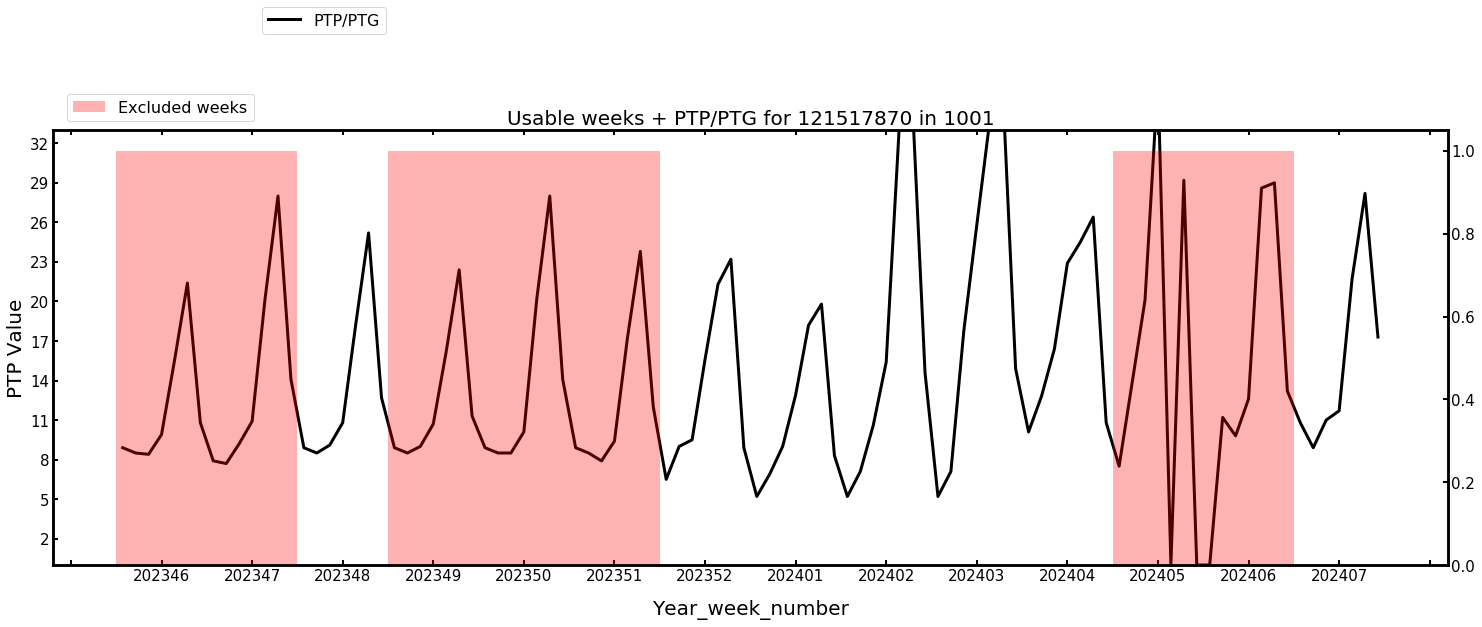

In [44]:
df_ind_c = df_indp.copy()
df_ind_c.sort_values(by='calendar_date_left',ascending=False)
df_ind_c = df_ind_c[df_ind_c['tesco_yrwk'].astype('str')<=str(lw)]
df_ind_c = df_ind_c.sort_values(by='calendar_date_left',ascending=False).iloc[:98]
df_ind_c['final_ptp_ptg'] = df_ind_c['ptg_value'].combine_first(df_ind_c['ptp_value'])
querycal = "SELECT calendar_date,year_week_number FROM lookup.calendar WHERE day_number = 1"
cal2 = spark.sql(querycal)       
cal2 = cal2.toPandas()
cal2['calendar_date'] = cal2['calendar_date'].astype('datetime64[ns]')
valid_pd2 = valid_pd.merge(cal2,left_on='tesco_yrwk_ModelRun',right_on='year_week_number',how='inner').drop(columns='year_week_number')
valid_pd2['calendar_date_min7'] = valid_pd2['calendar_date'].astype('datetime64[ns]') - pd.to_timedelta(7,unit='d')
valid_pd2 = valid_pd2.merge(cal2,left_on='calendar_date_min7',right_on='calendar_date',how='inner').drop(columns= ['calendar_date_x','calendar_date_min7'])
valid_pd2.rename(columns={'calendar_date_y':'iso_date_monday'},inplace=True)

df_ind_c2 = df_ind_c.merge(valid_pd2[['tesco_yrwk','num_valid']],on='tesco_yrwk',how='left').drop(columns='calendar_date_right')
df_ind_c2['num_valid'] = df_ind_c2['num_valid'].fillna(0)
df_ind_c2['valid_week'] = np.where(df_ind_c2['num_valid']==0,1,0)
df_ind_c2['weekly_sales'] = df_ind_c2.groupby(['base_product_number','retail_outlet_number','tesco_yrwk'])['adjusted_sales_singles'].transform("sum")
df_ind_c2['adj_sales_shape'] = df_ind_c2['adjusted_sales_singles']/df_ind_c2['weekly_sales']*100
df_ind_c2['adj_sales_shape'] = df_ind_c2['adj_sales_shape'].astype('float').round(1)
df_ind_c2['calendar_date_left'] = df_ind_c2['calendar_date_left'].astype('datetime64[ns]')
x = list(df_ind_c2['tesco_yrwk'].sort_values(ascending=True).unique())
x.insert(0,"")

#Plot results
fig,ax = plt.subplots(1,1,figsize=(25,8))
ax.plot(df_ind_c2['calendar_date_left'],df_ind_c2['final_ptp_ptg'],linewidth=3,color='black')
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=3, interval=1, tz=None))   
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())     
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
ax.set_xticklabels(x)
ax.legend(['PTP/PTG'],loc=(0.15,1.02),fontsize=16)
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
plt.ylabel('PTP Value',fontsize=20)
plt.xlabel('Year_week_number',fontsize=20)
ax.xaxis.set_label_coords(0.5, -.08)
plt.yticks([2.0,5.0,8.0,11.0,14.0,17.0,20.0,23.0,26.0,29.0,32.0])
plt.ylim(0,33)
ax2=ax.twinx()
ax2.bar(df_ind_c2['calendar_date_left'],df_ind_c2['valid_week'],color='r',alpha=0.3,width=1.0)
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=3, interval=1, tz=None))   
ax2.xaxis.set_minor_locator(mdates.WeekdayLocator())     
ax2.xaxis.set_minor_formatter(ticker.NullFormatter())
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
#(mdates.DayLocator(interval=7))
ax2.set_xticklabels(x)
ax2.legend(['Excluded weeks'],loc=(0.01,1.02),fontsize=16)
plt.title('Usable weeks + PTP/PTG for '+str(bpn)+' in '+str(rot),fontsize=20)
plt.show()

### Possible reactive PTP that could store-product combination get

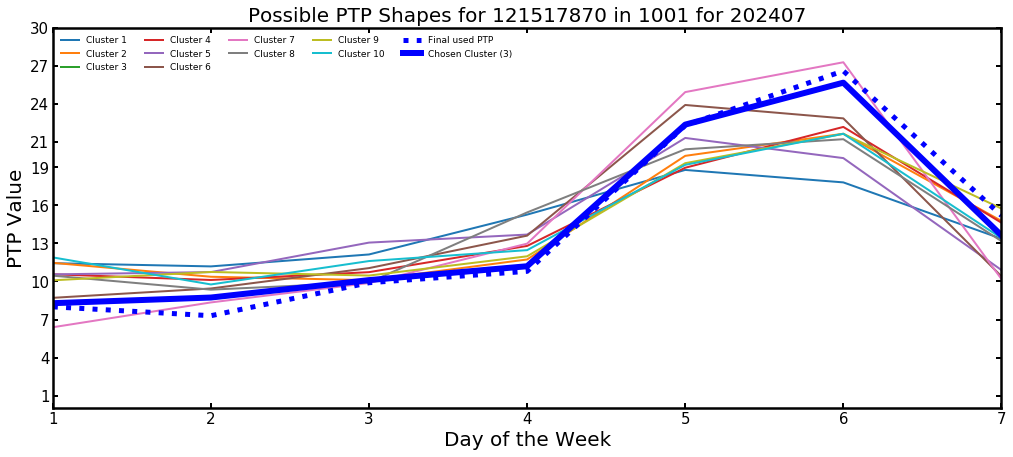

In [40]:
#This code builds a pandas dataframe from the pu table (called df_pu)
df_pu = spark.read.orc(pu_table)
df_pu = df_pu.filter(df_pu.base_product_number == bpn)
df_pu = df_pu.filter(df_pu.location_id == rot_id)
df_pu = df_pu.withColumn('retail_outlet_number',lit(rot))
df_pu = df_pu.toPandas()
df_pu = df_pu.sort_values(by=(['cluster','day']), ascending=True)

#This code builds a pandas dataframe from the data table (called df5) 
#(only 1 data table so data only valid if looking at last week)
df5 = spark.read.orc(data_table)
df5 = df5.filter(df5.base_product_number == bpn)
df5 = df5.filter(df5.location_id == rot_id)
df5 = df5.withColumn('retail_outlet_number',lit(rot))
df5 = df5.toPandas()
df5["Exponential_Sales_PTP"] = 100*(df5.adjusted_sales/(np.sum(df5.adjusted_sales)))
df5 = df5.sort_values(by=(['day_number']), ascending=True)

fig = plt.figure(figsize=(17,7))
for i in range(0,int(len(df_pu)/7)):
    dfcluster = df_pu[df_pu['cluster'] == i+1] 
    plt.plot(dfcluster.day,100*dfcluster.ptp,ls='-',lw=2, label = 'Cluster '+str(i+1))
dfcluster_selected = df_pu[df_pu['likelihood'] == df_pu['max_likelihood']] 
dfcluster_selected = dfcluster_selected.reset_index(drop=True)
#plt.plot(df5["day_number"].tolist(),df5["Exponential_Sales_PTP"].tolist(),lw=3,color='k', label = 'Exponential Sales PTP')
plt.plot(ensemble_g.Day,ensemble_g.PTP,ls='dotted',lw=5,color='blue',label = 'Final used PTP')
plt.plot(dfcluster_selected.day,100*dfcluster_selected.ptp,ls='-',lw=6, color='blue', label = 'Chosen Cluster ('+str(dfcluster_selected.cluster[0])+')')   
plt.xlabel('Day of the Week',fontsize=20)
plt.ylabel('PTP Value',fontsize=20)
plt.legend(frameon=False,fontsize=9,ncol=5)
plt.title('Possible PTP Shapes for '+str(bpn)+' in '+str(rot)+' for '+str(week),fontsize=20)
plt.xticks([1,2,3,4,5,6,7])
plt.yticks([1.0,4.0,7.0,10.0,13.0,16.0,19.0,21.0,24.0,27.0,30.0])
plt.xlim(1,7)
plt.ylim(0,30)
plt.show()

# PTG-PTP ratio

### History of PTG-PTP ratio

In [142]:
country = 'hu'

In [5]:
ptg_df = spark.read.orc('/insight_prod/rdf_archive/source_image/' + country + '/denorm_data_layer_final/')
ptg_df = ptg_df.select('base_product_number','retail_outlet_number','product_sub_group_code','year_week_number','calendar_date','ptg_value')
ptg_df.cache()

yrwks = ptg_df.select(col('year_week_number')).distinct().orderBy(col('year_week_number').desc())
window_spec = Window.orderBy(col('year_week_number').desc())
yrwks = yrwks.withColumn('row_number',row_number().over(window_spec))
yrwks = yrwks.toPandas()
yrwks = yrwks[(yrwks['row_number']<=28)&(yrwks['row_number']>0)]
yrwks_list = list(yrwks['year_week_number'])
ptg_df = ptg_df.filter(col('year_week_number').isin(yrwks_list))
ptg_df = ptg_df.withColumn('ptg_id',when(ptg_df.ptg_value.isNull(),'PTP').otherwise('PTG'))
ptg_df2 = ptg_df.groupby('year_week_number','ptg_id').count()
ptg_df2.createOrReplaceTempView('DATA')
ptg_df3 = spark.sql('SELECT year_week_number,ptg_id, count, SUM(count) OVER(PARTITION BY year_week_number) as total FROM DATA')
ptg_df_p = ptg_df3.toPandas()
ptg_df_p['country'] = country
ptg_df_p['%'] = np.round((ptg_df_p['count']/ptg_df_p['total']*100),1)
ptg_df_p.sort_values(by=['year_week_number','ptg_id'],ascending=[False,True],inplace=True)
ptg_df_p = ptg_df_p[ptg_df_p['ptg_id']=='PTG']
ptg_df_p.head(28)

NameError: name 'spark' is not defined

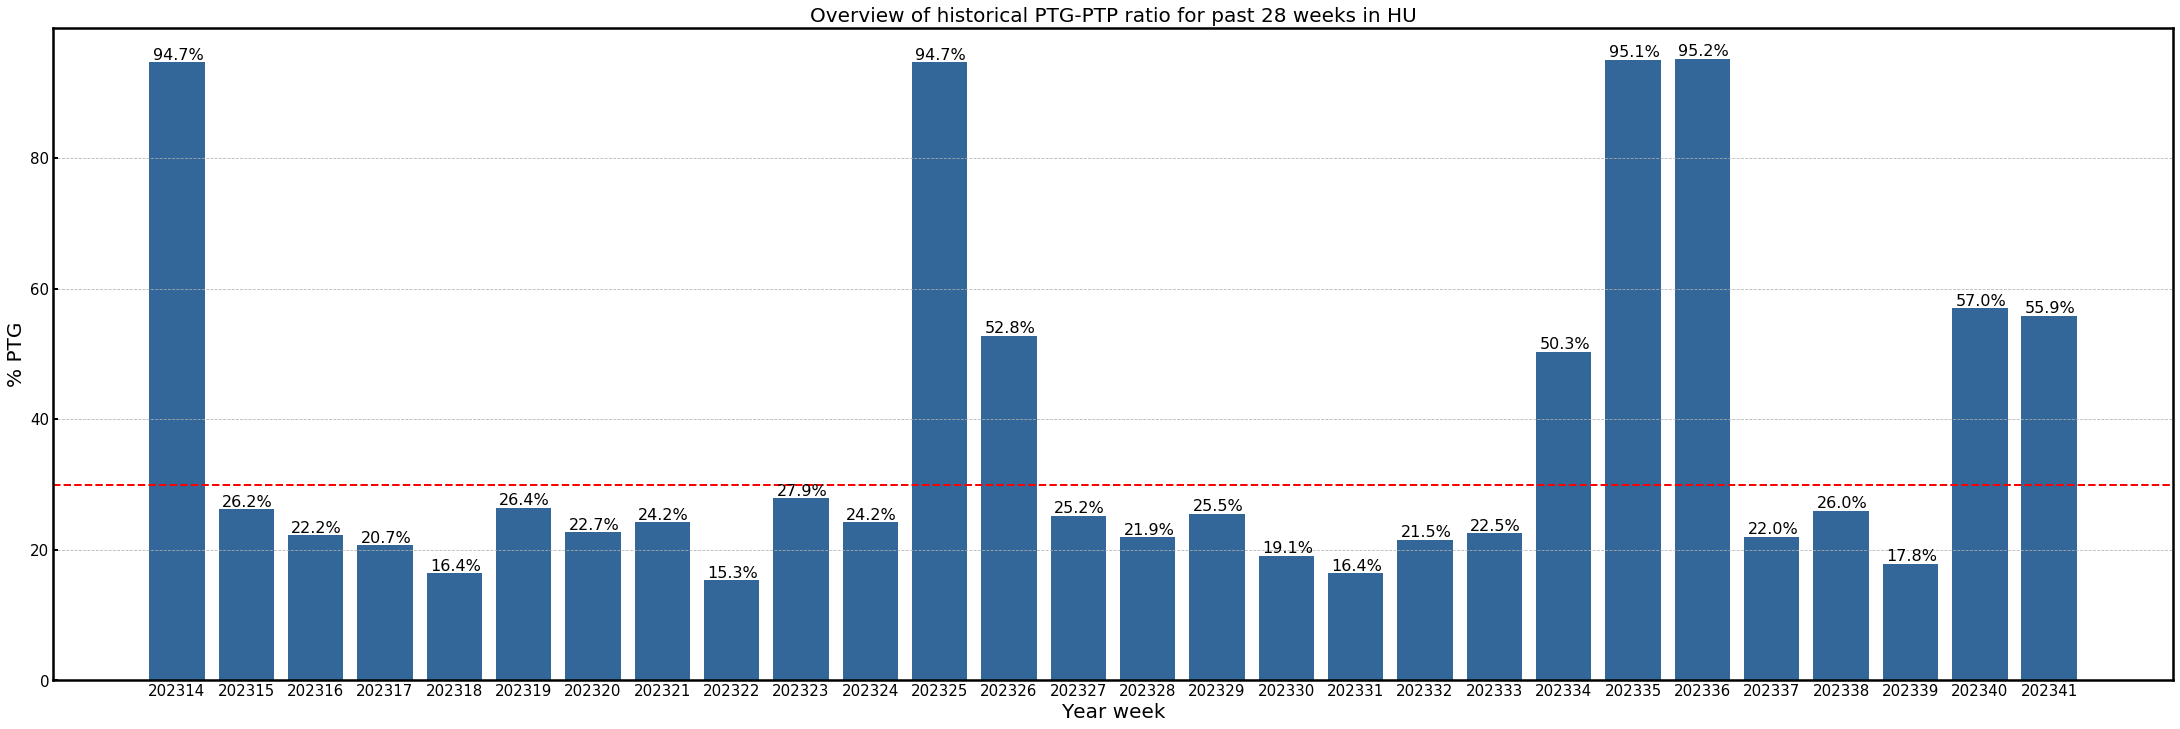

In [144]:
ptg_df_p['year_week_number'] = ptg_df_p['year_week_number'].astype('str')
ptg_df_p.sort_values(by=['year_week_number'],ascending=True,inplace=True)
plt.figure(figsize=(38,12))
bars = plt.bar(ptg_df_p['year_week_number'],ptg_df_p['%'],color=(0.2, 0.4, 0.6))
plt.ylabel('% PTG',fontsize=20)
plt.xlabel('Year week',fontsize=20)
plt.title("Overview of historical PTG-PTP ratio for past 28 weeks in "+ country.upper(),fontsize=20)
plt.tick_params(axis='x',which='both',bottom=False,top=False)
plt.tick_params(axis='y',which='both',left=True,right=False)
plt.grid(axis='y', linestyle='--', alpha=0.95)
plt.axhline(y=30,color='red',linestyle='--',linewidth=2,label='PTG threshold')
for bar,value in zip(bars,ptg_df_p['%']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.35, bar.get_height() + 0.44, f'{value:.1f}%', fontsize=16)  
plt.show()

### PTG-PTP ratio particular week

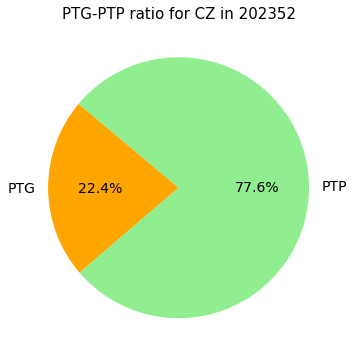

In [13]:
# Select correct week to analyse - current week can be also analysed
week = '202352'
country = 'cz'

ptg_df = spark.read.orc('/insight_prod/rdf_archive/source_image/' + country + '/denorm_data_layer_final/')
ptg_df = ptg_df.select('base_product_number','retail_outlet_number','product_sub_group_code','year_week_number','calendar_date','ptg_value')
ptg_df = ptg_df.filter(col('year_week_number')==week)

ptg_df = ptg_df.withColumn('ptg_id',when(ptg_df.ptg_value.isNull(),'PTP').otherwise('PTG'))
ptg_df2 = ptg_df.groupby('ptg_id').count()
ptg_df2.createOrReplaceTempView('DATA')
ptg_df3 = spark.sql('SELECT ptg_id, count, SUM(count) OVER() as total FROM DATA')
ptg_df_p = ptg_df3.toPandas()
ptg_df_p['%'] = np.round((ptg_df_p['count']/ptg_df_p['total']*100),1)
ptg_df_p.sort_values(by='ptg_id',ascending=True,inplace=True)
total_ptg = ptg_df_p.iloc[0,1]
plt.figure(figsize=(6, 6))
plt.pie(ptg_df_p['%'], labels=ptg_df_p['ptg_id'], autopct='%1.1f%%',textprops={'fontsize': 14}, startangle=140, colors=['orange', 'lightgreen'])
plt.title('PTG-PTP ratio for '+ country.upper() +' in '+week,fontsize=15)
plt.show()

##### PTG-PTP ratio dates available for week

In [ ]:
ptg_df2 = spark.read.orc('/insight_prod/rdf_archive/source_image/' + country + '/denorm_data_layer_final/')
ptg_df2 = ptg_df2.select('year_week_number','calendar_date')
ptg_df2 = ptg_df2.dropDuplicates()
ptg_df2 = ptg_df2.filter(col('year_week_number')==week)
ptg_df2.show()

### Top contributors from various sg_cd levels where PTGs were uploaded

#### 2nd level

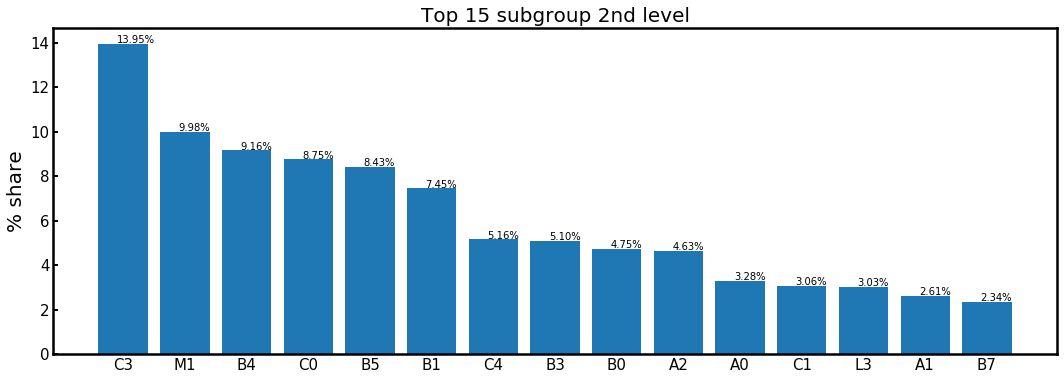

In [30]:
df_top2 = ptg_df.filter(col('ptg_id')=='PTG')
df_top2 = df_top2.withColumn('product_sub_group_code_2',substring('product_sub_group_code',1,2))
df_top2 = df_top2.groupby('product_sub_group_code_2').count()
df_top2_p = df_top2.toPandas()
df_top2_p['total_ptg'] = total_ptg
df_top2_p['%'] = np.round(df_top2_p['count']/df_top2_p['total_ptg']*100,2)
df_top2_p = df_top2_p.sort_values(by='count',ascending=False).head(15)
plt.figure(figsize=(18,6))
bars = plt.bar(df_top2_p['product_sub_group_code_2'],df_top2_p['%'])
plt.ylabel('% share',fontsize=20)
plt.title("Top 15 subgroup 2nd level",fontsize=20)
plt.tick_params(axis='x',which='both',bottom=False,top=False)
plt.tick_params(axis='y',which='both',left=True,right=False)
for bar, value in zip(bars, df_top2_p['%']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.3, bar.get_height() + 0.04, f'{value:.2f}%', fontsize=10)
plt.show()

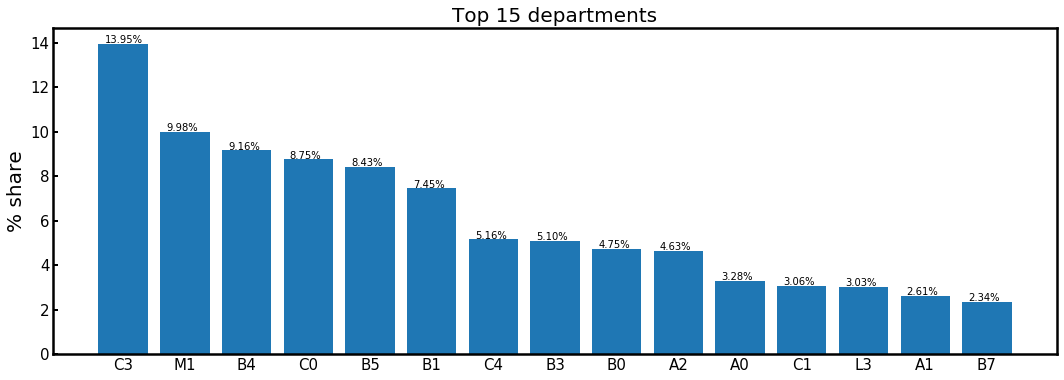

In [34]:
plt.figure(figsize=(18,6))
bars = plt.bar(df_top2_p['product_sub_group_code_2'],df_top2_p['%'])
plt.ylabel('% share',fontsize=20)
plt.title("Top 15 departments",fontsize=20)
plt.tick_params(axis='x',which='both',bottom=False,top=False)
plt.tick_params(axis='y',which='both',left=True,right=False)
for bar, value in zip(bars, df_top2_p['%']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.3, bar.get_height() + 0.04, f'{value:.2f}%', fontsize=10)
plt.show()

#### 3rd level

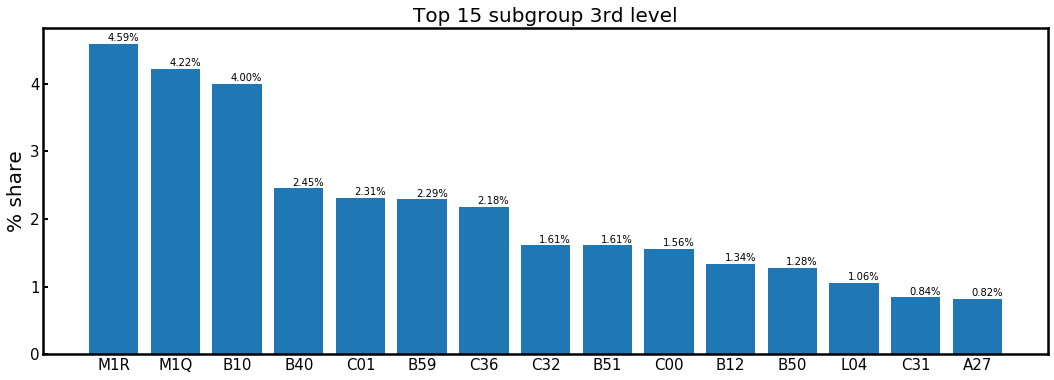

In [11]:
df_top3 = ptg_df.filter(col('ptg_id')=='PTG')
df_top3 = df_top3.withColumn('product_sub_group_code_3',substring('product_sub_group_code',1,3))
df_top3 = df_top3.groupby('product_sub_group_code_3').count()
df_top3_p = df_top3.toPandas()
df_top3_p['total_ptg'] = total_ptg
df_top3_p['%'] = np.round(df_top3_p['count']/df_top3_p['total_ptg']*100,2)
df_top3_p.sort_values(by='count',ascending=False).head(15)
df_top3_p = df_top3_p.sort_values(by='count',ascending=False).head(15)
plt.figure(figsize=(18,6))
bars = plt.bar(df_top3_p['product_sub_group_code_3'],df_top3_p['%'])
plt.ylabel('% share',fontsize=20)
plt.title("Top 15 sections",fontsize=20)
plt.tick_params(axis='x',which='both',bottom=False,top=False)
plt.tick_params(axis='y',which='both',left=True,right=False)
for bar, value in zip(bars, df_top3_p['%']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.04, f'{value:.2f}%', fontsize=10)
plt.show()

#### 4th level

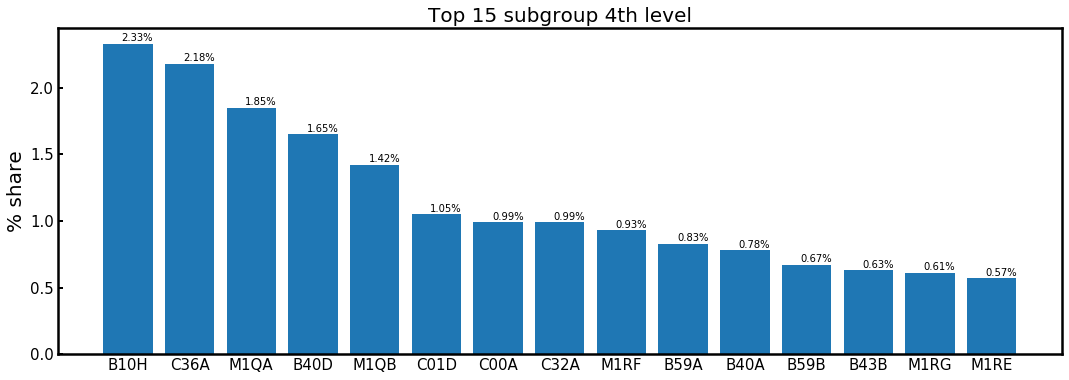

In [12]:
df_top4 = ptg_df.filter(col('ptg_id')=='PTG')
df_top4 = df_top4.withColumn('product_sub_group_code_4',substring('product_sub_group_code',1,4))
df_top4 = df_top4.groupby('product_sub_group_code_4').count()
df_top4_p = df_top4.toPandas()
df_top4_p['total_ptg'] = total_ptg
df_top4_p['%'] = np.round(df_top4_p['count']/df_top4_p['total_ptg']*100,2)
df_top4_p = df_top4_p.sort_values(by='count',ascending=False).head(15)
plt.figure(figsize=(18,6))
bars = plt.bar(df_top4_p['product_sub_group_code_4'],df_top4_p['%'])
plt.ylabel('% share',fontsize=20)
plt.title("Top 15 groups",fontsize=20)
plt.tick_params(axis='x',which='both',bottom=False,top=False)
plt.tick_params(axis='y',which='both',left=True,right=False)
for bar, value in zip(bars, df_top4_p['%']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}%', fontsize=10)
plt.show()

#### 5th level

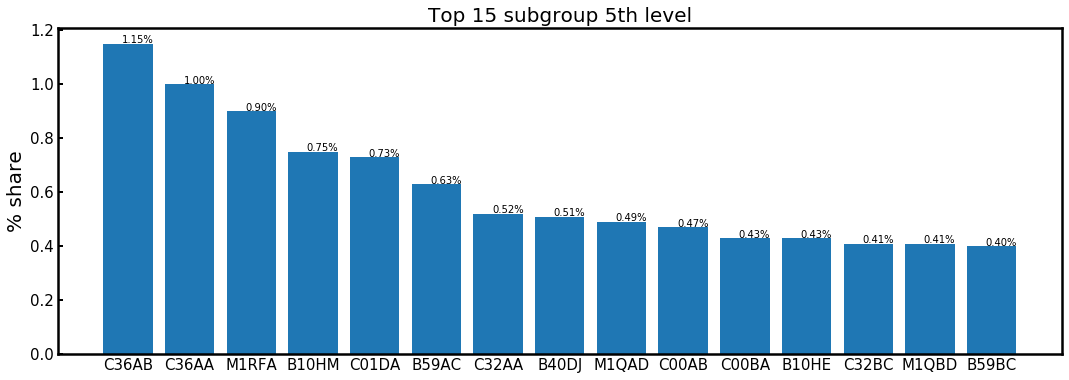

In [13]:
df_top5 = ptg_df.filter(col('ptg_id')=='PTG')
df_top5 = df_top5.groupby('product_sub_group_code').count()
df_top5_p = df_top5.toPandas()
df_top5_p['total_ptg'] = total_ptg
df_top5_p['%'] = np.round(df_top5_p['count']/df_top5_p['total_ptg']*100,2)
df_top5_p = df_top5_p.sort_values(by='count',ascending=False).head(15)
plt.figure(figsize=(18,6))
bars = plt.bar(df_top5_p['product_sub_group_code'],df_top5_p['%'])
plt.ylabel('% share',fontsize=20)
plt.title("Top 15 subgroups",fontsize=20)
plt.tick_params(axis='x',which='both',bottom=False,top=False)
plt.tick_params(axis='y',which='both',left=True,right=False)
for bar, value in zip(bars, df_top5_p['%']):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.002, f'{value:.2f}%', fontsize=10)
plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# PTP coverage stores - subgroups

## All stores reactive PTP % coverage - last run

In [9]:
# Reactive PTP SG_CD counts
df_cover = spark.read.csv(output_table)
df_cover = df_cover.filter((col('_c2')<1))
df_cover = df_cover.toPandas()
df_cover = df_cover[['_c0','_c1','_c3']]
df_cover['ptp_run_date'] = ow
df_cover['country'] = country
df_cover.rename(columns={'_c0':'store','_c1':'sg_cd','_c2':'tesco_yrwk_start'},inplace=True)
df_cover['store'] = df_cover['store'].str[1:].astype(int)
df_cover_gp = df_cover.groupby(['country','ptp_run_date','store'])['sg_cd'].nunique().reset_index(name='reactive_ptp_sgcd')

In [10]:
# All sg cd counts from historical sales
query = "SELECT calendar_date, branch_number, count(distinct(product_sub_group_code)) as total_sgcd FROM sales_forecast.adjusted_forecast_sales WHERE SUBSTR(product_sub_group_code,1,1) IN ('A','B','C','L','M') AND country_code = '" + str(country) + "' AND calendar_date ='" + str(ow) +"' GROUP BY calendar_date,branch_number"
allsgcd = spark.sql(query)
allsgcd = allsgcd.toPandas()

In [11]:
# All sg cd counts from data layer
df_allsg = spark.read.orc(data_layer)
df_allsg.createOrReplaceTempView('ALLDATA')
lastday = (pd.to_datetime(ow)-pd.Timedelta(days=1)).date()
lastday = lastday.strftime('%Y-%m-%d')
query2 = "SELECT retail_outlet_number, COUNT(DISTINCT product_sub_group_code) as counts FROM ALLDATA WHERE calendar_date ='" + str(lastday) + "' GROUP BY retail_outlet_number"
df_uniq = spark.sql(query2)
df_uniq_p = df_uniq.toPandas()

In [12]:
df_cover_final = df_cover_gp.merge(allsgcd,how='left',left_on=['ptp_run_date','store'],right_on=['calendar_date','branch_number'])
df_cover_final.drop(columns='calendar_date',inplace=True)
df_cover_final['reactive_ptp_coverage_%'] = df_cover_final['reactive_ptp_sgcd']/df_cover_final['total_sgcd']*100
filename = 'react_ptp_coverage_' + str(country) + ".csv"
df_cover_final.to_csv(filename,index=True)

## Store selection

In [13]:
rot_n = 1014

### Extracting sg_cd for which shapes were not generated

In [14]:
query = "SELECT distinct calendar_date, branch_number as store, product_sub_group_code as sg_cd FROM sales_forecast.adjusted_forecast_sales WHERE SUBSTR(product_sub_group_code,1,1) IN ('A','B','C','L','M') AND country_code = '" + str(country) + "' AND calendar_date ='" + str(ow) +"' AND branch_number = '" + str(rot_n) + "'"
allsgcd_2 = spark.sql(query)
allsgcd_2 = allsgcd_2.toPandas()

In [15]:
df_antijoin = allsgcd_2.merge(df_cover,how='left',left_on=['calendar_date','sg_cd','store'],right_on=['ptp_run_date','sg_cd','store'])
df_antijoin = df_antijoin[pd.isna(df_antijoin['country'])]
anti_sgcd = df_antijoin['sg_cd'].tolist()
anti_sgcd

['M1QBJ',
 'C39DA',
 'B51DD',
 'A54AH',
 'A10EA',
 'A26HA',
 'M2OJJ',
 'A67BA',
 'C10GB',
 'M03FB',
 'A6BAB',
 'M1QAR',
 'M2GBB',
 'M1QAQ',
 'C3BBA',
 'M1QEG',
 'L04AN',
 'L0H1C',
 'A04BE',
 'L0GAV',
 'A71CE',
 'A04ED',
 'A51EH',
 'L0GAT',
 'B40DK',
 'B51FB',
 'M2GBA',
 'C36AC',
 'C36AA',
 'A26CD',
 'B35BB',
 'L0GAU',
 'B03AA',
 'C32EA',
 'L0GAR',
 'A14CD',
 'M2GHA',
 'A68CB',
 'L50AB',
 'B33BJ',
 'M1RFB',
 'A22BB',
 'B71AA',
 'A51BG',
 'M1SBO',
 'A51BC',
 'B62AA',
 'M1QBK',
 'L0HEB',
 'B55CB',
 'L0KDB',
 'C10GA',
 'A13GA',
 'A26IB',
 'M1QDD',
 'B10HI',
 'M2GBE',
 'A40AA',
 'L0GAQ',
 'L03AD',
 'C32CE',
 'A14EC',
 'C36CD',
 'M1QBP',
 'M1QDC',
 'C36AB',
 'L03AJ',
 'A50DO',
 'L04YD',
 'B61AC',
 'M1QFE',
 'A26IF',
 'C31FD',
 'M2OHJ',
 'L0GAG',
 'M20BD',
 'A20BA',
 'B10HJ',
 'B51GB',
 'M1QBM',
 'B40DH',
 'M1QCE',
 'C20BB',
 'B51CE',
 'M1QEF',
 'L2YEB',
 'A33BB',
 'B40AB',
 'A23CC',
 'L0GAM',
 'L0GAO',
 'A03GA',
 'B10HK',
 'L041C',
 'C31GB',
 'M1RGE',
 'A73FI',
 'A04CE',
 'C42AF',
 'M01BA',


### Overview store and sg_cd ptp generated coverage (used mainly for new stores)

In [21]:
new_df = spark.read.orc(sphist)
new_df = new_df.filter(new_df.retail_outlet_number == rot_n)
new_df = new_df.filter(new_df.execution_date == ow)
new_df = new_df.select(col('retail_outlet_number'),col('base_product_number'),col('year_week_number'),col('num_valid'),col('execution_date'))
new_df = new_df.orderBy(new_df.year_week_number.asc())
new_df = new_df.toPandas()
firstopeningweek = new_df.iloc[0,2].copy()

df_sgcd_new = df_info2[df_info2['year_week_number']>firstopeningweek].sort_values(by='year_week_number',ascending=True)
after_6_valid_weeks_1 = df_sgcd_new.iloc[5,1].strftime('%Y-%m-%d') 
after_6_valid_weeks_2 = df_sgcd_new.iloc[6,1].strftime('%Y-%m-%d') 
after_6_valid_weeks_3 = df_sgcd_new.iloc[7,1].strftime('%Y-%m-%d') 
after_6_valid_weeks_4 = df_sgcd_new.iloc[-2,1].strftime('%Y-%m-%d') 
after_6_valid_weeks_5 = df_sgcd_new.iloc[-1,1].strftime('%Y-%m-%d') 
output_table_n1 = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+after_6_valid_weeks_1
output_table_n2 = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+after_6_valid_weeks_2
output_table_n3 = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+after_6_valid_weeks_3
output_table_n4 = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+after_6_valid_weeks_4
output_table_n5 = '/insight_prod/rdf_archive/output/ptp/reactive_ptp/' + country + '/denormalised_ptp_csv_'+after_6_valid_weeks_5

outputdf_n1 = spark.read.csv(output_table_n1)
outputdf_n1 = outputdf_n1.filter((col('_c2')<1)&(substring(col('_c0'),2,4).isin(rot_n)))
n1 = outputdf_n1.count()

outputdf_n2 = spark.read.csv(output_table_n2)
outputdf_n2 = outputdf_n2.filter((col('_c2')<1)&(substring(col('_c0'),2,4).isin(rot_n)))
n2 = outputdf_n2.count()

outputdf_n3 = spark.read.csv(output_table_n3)
outputdf_n3 = outputdf_n3.filter((col('_c2')<1)&(substring(col('_c0'),2,4).isin(rot_n)))
n3 = outputdf_n3.count()

outputdf_n4 = spark.read.csv(output_table_n4)
outputdf_n4 = outputdf_n4.filter((col('_c2')<1)&(substring(col('_c0'),2,4).isin(rot_n)))
n4 = outputdf_n4.count()

outputdf_n5 = spark.read.csv(output_table_n5)
outputdf_n5 = outputdf_n5.filter((col('_c2')<1)&(substring(col('_c0'),2,4).isin(rot_n)))
n5 = outputdf_n5.count()

new_store_df = pd.DataFrame({'ptp_run_date':[after_6_valid_weeks_1,after_6_valid_weeks_2,after_6_valid_weeks_3,after_6_valid_weeks_4,after_6_valid_weeks_5],'reactive_ptp_sgcd':[n1,n2,n3,n4,n5]})
new_store_df['store'] = rot_n
new_store_df['country'] = country
new_store_df['first_opening_week'] = firstopeningweek
cal = spark.sql("SELECT calendar_date,year_week_number FROM lookup.calendar WHERE day_number = 1 AND calendar_date > '2022-01-01'")
cal = cal.toPandas()
new_store_df = new_store_df.merge(cal,how='left',left_on='first_opening_week',right_on='year_week_number')
new_store_df.drop(columns='year_week_number',inplace=True)
new_store_df['weeks_open'] = ((pd.to_datetime(new_store_df['ptp_run_date']) - pd.to_datetime(new_store_df['calendar_date'])).dt.days/7).astype(int)

query = "SELECT calendar_date, count(distinct(product_sub_group_code)) as total_sgcd FROM sales_forecast.adjusted_forecast_sales WHERE branch_number =" +str(rot_n) + " AND country_code = '" + str(country) + "' AND calendar_date > '2022-01-01' GROUP BY calendar_date"
allsgcd = spark.sql(query)
allsgcd = allsgcd.toPandas()
new_store_df.drop(columns='calendar_date',inplace=True)
new_store_df = new_store_df.merge(allsgcd,how='left',left_on='ptp_run_date',right_on='calendar_date')
new_store_df['reactive_ptp_coverage_%'] = new_store_df['reactive_ptp_sgcd']/new_store_df['total_sgcd']*100
new_store_df.drop(columns='calendar_date',inplace=True)
new_store_df

,ptp_run_date,reactive_ptp_sgcd,store,country,first_opening_week,weeks_open,total_sgcd,reactive_ptp_coverage_%
0,2023-10-02,0,4168,sk,202319,13,986,0.000000
1,2023-10-09,0,4168,sk,202319,14,992,0.000000
2,2023-10-16,8,4168,sk,202319,15,979,0.817160
3,2023-10-30,25,4168,sk,202319,17,994,2.515091
4,2023-11-13,41,4168,sk,202319,19,989,4.145602


### Store sphist, ptp, ptg breakdown 

In [16]:
data_layer_df = spark.read.orc(data_layer)
data_layer_df = data_layer_df.filter(data_layer_df.retail_outlet_number == rot_n)
# Only for existing store
data_layer_df = data_layer_df.filter(data_layer_df.product_sub_group_code.isin(anti_sgcd))

data_layer_df.createOrReplaceTempView('DATA')
query = """SELECT distinct base_product_number as tpnb
,retail_outlet_number as store
,store_name as store_desc
,store_opening_date as store_open_date
,product_sub_group_code as sg_cd
,year_week_number as tesco_yrwk
,Sum(CASE WHEN unuse_indicator IN ('N','Z') THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS unuse_ind_N_Z
,Sum(CASE WHEN unuse_indicator = 'Y' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS unuse_ind_Y
,Sum(CASE WHEN unuse_indicator = 'X' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS unuse_ind_X
,Sum(CASE WHEN step_indicator = 'N' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS Step_N
,Sum(CASE WHEN step_indicator = 'S' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS Step_S 
,Sum(CASE WHEN step_indicator = 'B' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS Step_B 
,Sum(CASE WHEN step_indicator = 'P' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS Step_P 
,Sum(CASE WHEN step_indicator = 'M' THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS Step_M
,Sum(CASE WHEN ptg_value >= 0 THEN 1 ELSE 0 END) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS ptg_count
,Sum(adjusted_sales_singles) Over(PARTITION BY product_sub_group_code, base_product_number, retail_outlet_number,year_week_number) AS sum_adj_sales
FROM DATA
WHERE product_group_division_code IN ('A','B','C','L','M')
"""
df_layer = spark.sql(query)
df_layer_p = df_layer.toPandas()

In [21]:
df_d = spark.read.orc(sphist)
df_d = df_d.filter(df_d.retail_outlet_number == rot_n)
unique_tpnb = df_layer_p['tpnb'].unique().tolist()
df_d = df_d.filter(df_d.base_product_number.isin(unique_tpnb))
df_d = df_d.filter(df_d.execution_date == ow)
df_d = df_d.withColumnRenamed('year_week_number','yrwk_model_run')
df_d = df_d.orderBy(df_d.yrwk_model_run.asc())
df_d = df_d.toPandas()

calquery="""SELECT b.calendar_date
,b.year_week_number as yrwk
,a.calendar_date as calendar_date_lw
,a.year_week_number as year_week_number_lw 
FROM lookup.calendar as b
INNER JOIN lookup.calendar as a
ON a.calendar_date = DATE_ADD(b.calendar_date,-7)
WHERE b.day_number = 1 AND b.calendar_date > '2022-10-01'
"""
cal = spark.sql(calquery)
cal = cal.toPandas()

df_d = df_d.merge(cal,how='inner',left_on='yrwk_model_run',right_on='yrwk')
df_d.drop(columns=['calendar_date','calendar_date_lw','yrwk_model_run'],inplace=True)
df_d.rename(columns={'year_week_number_lw':'year_week_number'},inplace=True)

In [22]:
df_d_fin = df_d.merge(df_layer_p,how='inner',left_on=['year_week_number','retail_outlet_number','base_product_number'],right_on=['tesco_yrwk','store','tpnb'])
df_d_fin.rename(columns={'sum_sales':'sphist_sales'},inplace=True)
col_order = ['store','store_desc','store_open_date','tpnb','sg_cd','tesco_yrwk','num_valid','unuse_ind_N_Z','unuse_ind_Y','unuse_ind_X','Step_N','Step_S','Step_B','Step_P','Step_M','ptg_count','sphist_sales','sum_adj_sales']
df_d_fin = df_d_fin.loc[:,col_order]
df_d_fin[['store','num_valid','unuse_ind_N_Z','unuse_ind_Y','unuse_ind_X','Step_N','Step_S','Step_B','Step_M','ptg_count']] = df_d_fin[['store','num_valid','unuse_ind_N_Z','unuse_ind_Y','unuse_ind_X','Step_N','Step_S','Step_B','Step_M','ptg_count']].fillna(0).astype(int)
df_d_fin.sort_values(by=['store','tpnb','tesco_yrwk'],ascending=[True,True,True],inplace=True)
#df_d_fin['cumsum_num_valid'] = df_d_fin.groupby(['tpnb','store'])['num_valid'].cumsum()
#df_d_fin['cumsum_sphist_sales'] = df_d_fin.groupby(['tpnb','store'])['sphist_sales'].cumsum()
df_d_fin['valid_week'] = np.where(df_d_fin['num_valid'] > 0, 1, 0)
#df_d_fin['cumsum_valid_week'] = df_d_fin.groupby(['tpnb','store'])['valid_week'].cumsum()
df_d_fin['roll_12w_valid_days'] = df_d_fin.groupby(['tpnb','store'])['num_valid'].rolling(window=12,min_periods=1).sum().reset_index(level=[0, 1], drop=True)
df_d_fin['roll_12w_valid_week'] = df_d_fin.groupby(['tpnb','store'])['valid_week'].rolling(window=12,min_periods=1).sum().reset_index(level=[0, 1], drop=True)
df_d_fin['roll_12w_sphist_sales'] = df_d_fin.groupby(['tpnb','store'])['sphist_sales'].rolling(window=12,min_periods=1).sum().reset_index(level=[0, 1], drop=True)
filename = 'store_'+str(rot_n)+'_sphist_ptg_steps.csv'
df_d_fin.to_csv(filename,index=False)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# SIM_ID check hierarchy

In [25]:
!hdfs dfs -ls hdfs://nnproxies/insight_prod/rdf/output/ptp/reactive_ptp/

ls: `hdfs://nnproxies/insight_prod/rdf/output/ptp/reactive_ptp/': No such file or directory


In [15]:
df_simid = spark.read.orc('/insight_uat/rdf/output/ptp/reactive_ptp/hu/multi_model/trial/threshold_25/reactive_ptp_final_output/execution_date=2023-10-09 00%3A00%3A00')
df_simid = df_simid.select(col('Base_Product_Number'),col('sim_id')).distinct()
df_simid = df_simid.filter(col('sim_id')==1)
df_simid.cache()
query = "SELECT distinct tpnb as base_product_number, product_sub_group_code FROM sales_forecast.adjusted_forecast_sales WHERE country_code = '" + str(country) + "' AND calendar_date ='" + str('2023-10-09') +"'"
hierarchy_df = spark.sql(query)
df_simid = df_simid.join(hierarchy_df,hierarchy_df.base_product_number==df_simid.Base_Product_Number,'left').select(df_simid['*'],hierarchy_df.product_sub_group_code)
df_simid = df_simid.withColumn('department',col('product_sub_group_code').substr(1,2))
df_simid_g = df_simid.groupBy('department').agg(count('Base_Product_Number').alias('distinct_product_counts'))
df_simid_g.show(20)

+----------+-----------------------+
|department|distinct_product_counts|
+----------+-----------------------+
|      null|                    502|
|        C3|                      4|
|        M2|                    262|
|        L2|                     13|
|        M0|                    273|
|        M1|                   2228|
|        M5|                      9|
|        L3|                   1575|
|        L0|                   3271|
+----------+-----------------------+



In [16]:
df_simid.filter(col('department')=='C3').show(5)

+-------------------+------+----------------------+----------+
|Base_Product_Number|sim_id|product_sub_group_code|department|
+-------------------+------+----------------------+----------+
|          220329612|     1|                 C3GBA|        C3|
|          220329610|     1|                 C3GBA|        C3|
|          220329605|     1|                 C3GBA|        C3|
|          220329609|     1|                 C3GBA|        C3|
+-------------------+------+----------------------+----------+



In [26]:
df_simid = spark.read.orc('/insight_uat/rdf/output/ptp/reactive_ptp/hu/multi_model/trial/threshold_25/reactive_ptp_final_output/execution_date=2023-10-09 00%3A00%3A00')
df_simid = df_simid.select(col('Base_Product_Number'),col('sim_id')).distinct()
df_simid = df_simid.filter(col('sim_id')==1)
df_simid.cache()
query = "SELECT * FROM product.tpnb_hierarchy WHERE country_code = 'HU'"
hierarchy_df = spark.sql(query)
df_simid = df_simid.join(hierarchy_df,hierarchy_df.tpnb==df_simid.Base_Product_Number,'left').select(df_simid['*'],hierarchy_df.division_name,hierarchy_df.division_code,hierarchy_df.department_name,hierarchy_df.department_code)
df_simid_g = df_simid.groupBy('sim_id','division_code','department_code','department_name').agg(count('Base_Product_Number').alias('distinct_product_counts'))
df_simid_g.show(20)

+------+-------------+---------------+---------------+-----------------------+
|sim_id|division_code|department_code|department_name|distinct_product_counts|
+------+-------------+---------------+---------------+-----------------------+
|     6|           03|           0331|HomeClean_Consm|                    693|
|     8|           03|           0332|            Pet|                    331|
|     4|           03|           0335|      Baby_Care|                     84|
|     4|           03|           0334|Health & Beauty|                    377|
|     2|           03|           0334|Health & Beauty|                   2264|
|     8|           03|           0338|Coupon_n_Pharma|                      1|
|     6|           03|           0332|            Pet|                     83|
|    10|           03|           0334|Health & Beauty|                    636|
|     7|           03|           0334|Health & Beauty|                    144|
|     8|           03|           0331|HomeClean_Cons

In [20]:
df_simid = spark.read.orc('/insight_uat/rdf/output/ptp/reactive_ptp/hu/multi_model/trial/threshold_25/reactive_ptp_final_output/execution_date=2023-10-09 00%3A00%3A00')
df_simid = df_simid.select(col('Base_Product_Number'),col('sim_id')).distinct()
df_simid.cache()
query = "SELECT * FROM product.tpnb_hierarchy WHERE country_code = 'HU'"
hierarchy_df = spark.sql(query)
df_simid = df_simid.join(hierarchy_df,hierarchy_df.tpnb==df_simid.Base_Product_Number,'left').select(df_simid['*'],hierarchy_df.division_name,hierarchy_df.division_code,hierarchy_df.department_name,hierarchy_df.department_code)
df_simid_g = df_simid.groupBy('division_code','department_code','department_name','sim_id').agg(count('Base_Product_Number').alias('distinct_product_counts'))
df_simid_g = df_simid_g.filter(col('department_name')=='Health & Beauty')
df_simid_g.show(30)

+-------------+---------------+---------------+------+-----------------------+
|division_code|department_code|department_name|sim_id|distinct_product_counts|
+-------------+---------------+---------------+------+-----------------------+
|           03|           0334|Health & Beauty|     2|                   2266|
|           03|           0334|Health & Beauty|    11|                     45|
|           03|           0334|Health & Beauty|     4|                    377|
|           03|           0334|Health & Beauty|    12|                    105|
|           03|           0334|Health & Beauty|     7|                    144|
|           03|           0334|Health & Beauty|     3|                    142|
|           03|           0334|Health & Beauty|     1|                      4|
|           03|           0334|Health & Beauty|     6|                   2268|
|           03|           0334|Health & Beauty|     8|                    373|
|           03|           0334|Health & Beauty|    1

In [27]:
df_simid = spark.read.orc('/insight_uat/rdf/output/ptp/reactive_ptp/hu/multi_model/trial/threshold_25/reactive_ptp_final_output/execution_date=2023-10-09 00%3A00%3A00')
df_simid = df_simid.select(col('Base_Product_Number'),col('sim_id')).distinct()
df_simid.cache()
query = "SELECT * FROM product.tpnb_hierarchy WHERE country_code = 'HU'"
hierarchy_df = spark.sql(query)
df_simid = df_simid.join(hierarchy_df,hierarchy_df.tpnb==df_simid.Base_Product_Number,'left').select(df_simid['*'],hierarchy_df.division_name,hierarchy_df.division_code,hierarchy_df.department_name,hierarchy_df.department_code,hierarchy_df.section_code,hierarchy_df.section_name,hierarchy_df.class_code.alias('group_code'),hierarchy_df.class_name.alias('group_name'),hierarchy_df.subclass_code,hierarchy_df.subclass_name)
df_simid = df_simid.filter(col('department_name')=='Health & Beauty')

query = "SELECT distinct tpnb as base_product_number, product_sub_group_code FROM sales_forecast.adjusted_forecast_sales WHERE country_code = '" + str(country) + "' AND calendar_date ='" + str('2023-10-09') +"'"
hierarchy2_df = spark.sql(query)
df_simid = df_simid.join(hierarchy2_df,hierarchy2_df.base_product_number==df_simid.Base_Product_Number,'left').select(df_simid['*'],hierarchy2_df.product_sub_group_code)
df_simid = df_simid.withColumn('section',substring(col('product_sub_group_code'),1,3))
df_simid = df_simid.withColumn('group',substring(col('product_sub_group_code'),1,4))
df_simid = df_simid.withColumn('subgroup',substring(col('product_sub_group_code'),1,5))
df_simid_g = df_simid.groupBy('division_code','department_code','department_name','section_code','section_name','group_code','group_name','section','group','sim_id').agg(count('Base_Product_Number').alias('distinct_product_counts'))
df_simid_final = df_simid_g.toPandas()
df_simid_final.head() #.to_csv('sim1.csv',index=False)

,division_code,department_code,department_name,section_code,section_name,group_code,group_name,section,group,sim_id,distinct_product_counts
0,03,0334,Health & Beauty,03343405,Season,0334340513,Travel_packs,C34,C34C,2,5
1,03,0334,Health & Beauty,03343404,Pharmacy,0334340415,Kids,None,None,2,1
2,03,0334,Health & Beauty,03343413,Pharmacy_shop,0334341313,Medical_material,C3C,C3CC,2,2
3,03,0334,Health & Beauty,03343409,Femme_Care,0334340916,Cotton_pads,None,None,2,3
4,03,0334,Health & Beauty,03343402,Face_n_body_care,0334340214,Body_care,None,None,10,1


In [28]:
df_simid_g = df_simid.groupBy('division_code','department_code','department_name','section_code','section_name','section','sim_id').agg(count('Base_Product_Number').alias('distinct_product_counts'))
df_simid_final = df_simid_g.toPandas()
df_simid_final.head(50) #.to_csv('sim1.csv',index=False)

,division_code,department_code,department_name,section_code,section_name,section,sim_id,distinct_product_counts
0,03,0334,Health & Beauty,03343412,Oral_Care,None,10,11
1,03,0334,Health & Beauty,03343407,Bath,C31,2,11
2,03,0334,Health & Beauty,03343402,Face_n_body_care,C31,2,221
3,03,0334,Health & Beauty,03343412,Oral_Care,C3B,6,158
4,03,0334,Health & Beauty,03343404,Pharmacy,C33,11,13
5,03,0334,Health & Beauty,03343403,Hair_care,C32,8,2
6,03,0334,Health & Beauty,03343407,Bath,None,2,61
7,03,0334,Health & Beauty,03343405,Season,C34,2,10
8,03,0334,Health & Beauty,03343409,Femme_Care,C38,4,19
9,03,0334,Health & Beauty,03343404,Pharmacy,None,2,14


In [29]:
df_simid_final[df_simid_final['section']=='C3G'].head(50)

,division_code,department_code,department_name,section_code,section_name,section,sim_id,distinct_product_counts
115,03,0334,Health & Beauty,03343477,CS1 H&B,C3G,1,4


### Hierarchy cluster assignment

In [20]:
df = spark.read.orc('/insight_prod/rdf_archive/output/ptp/reactive_ptp/product_hierarchy_cluster_assignment/country=sk')
df.show()

+---------------+-------------------------------------+---------+
|hierarchy_level|department_custom_cluster_description|year_week|
+---------------+-------------------------------------+---------+
|            A23|                   subgroup_cluster_4|   202401|
|              K|                            Hardlines|   202401|
|           M03F|                            Hardlines|   202401|
|           A27E|                   subgroup_cluster_4|   202401|
|           A27F|                   subgroup_cluster_0|   202401|
|           L042|                            Hardlines|   202401|
|           C3DB|                   subgroup_cluster_4|   202401|
|           A11D|                   subgroup_cluster_0|   202401|
|            B01|                   subgroup_cluster_0|   202401|
|           B03C|                   subgroup_cluster_0|   202401|
|           B10F|                   subgroup_cluster_4|   202401|
|           B62A|                   subgroup_cluster_4|   202401|
|         